Cryptocurrency trading bot.

Global variable definitions.

In [1]:
assets = ['KAVA', 'BNB', 'BTC', 'USDT']
intervals = ['1m']
all_pairs = False
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install plotly python-binance --upgrade --no-cache-dir

Requirement already up-to-date: plotly in ./anaconda3/lib/python3.7/site-packages (4.8.1)
Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from twisted.internet import reactor
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset=None, plot=False):
        if dataset is not None:
            self.dataset = dataset

        self.value = self.calculate(self.dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print(self.name)
        print(value)
        plt.plot(value)
        plt.show()

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print(self.name)
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()


class Cryptocurrency_indicators_base:
    def __init__(self):
        self.indicators = None

    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def _calculate_heikin_ashi_(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 6

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_heikin_ashi(self, df):
        heikin_ashi = self.calculate_simple_moving_average(df, window=1)
        heikin_ashi = self._calculate_heikin_ashi_(heikin_ashi)
        heikin_ashi = self.calculate_exponential_moving_average(heikin_ashi, window=1)

        return heikin_ashi

    def _calculate_RSI_(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_RSI_6(self, ticker):
        return self._calculate_RSI_(ticker, span=6)

    def calculate_RSI_12(self, ticker):
        return self._calculate_RSI_(ticker, span=12)

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        method='simple'):

        volume_average = self._calculate_moving_average_(dataset, 
                                                         window=average_1, 
                                                         method=method)

        relative_volume = dataset / average_1

        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, 
                                                                   window=average_2, 
                                                                   method=method)

        return smoothed_relative_volume[['volume']].pct_change()


class Cryptocurrency_triggers:
    def __init__(self):
        self.indicators = Cryptocurrency_indicators_base()

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.heikin_ashi.value
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.RSI_6.value
        RSI_12 = self.indicators.RSI_12.value
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.average_directional_index.value
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.average_directional_index.value
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.average_directional_index.value
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.KDJ.value
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.bollinger_bands.value
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.MACD.value
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0

    def calculate_relative_volume_level_trigger(self, dataset, threshold=1.5):
        relative_volume_level = self.indicators.relative_volume_level.value
        return relative_volume_level['volume'] > threshold


class Cryptocurrency_indicators:
    def __init__(self):
        self.indicators = Cryptocurrency_triggers()
        self.setup()

    def setup(self):
        self._setup_(self.indicators)

    def update(self, dataset, plot=False):
        self._update_(self.indicators, dataset, plot=plot)

    def _setup_(self, cls):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._setup_(next_indicators)

        indicators = [indicator for indicator in dir(cls) if indicator.startswith('calculate_')]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for indicator, calculator in zip(indicators, calculators):
            setattr(cls, 
                    indicator[10:], 
                    Cryptocurrency_indicator(name=indicator[10:], 
                                             calculate=calculator, 
                                             OHLC=False))

    def _update_(self, cls, dataset, plot=False):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._update_(next_indicators, dataset, plot=plot)

        indicators = [indicator for indicator in dir(cls)]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for calculator in calculators:
            if isinstance(calculator, Cryptocurrency_indicator):
                calculator.update(dataset, plot=plot)


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']
        self.base_asset_precision = pair_info['baseAssetPrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])        
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_buy_balance = float(self.quote_asset_balance) / float(self.pair_last_price)
        self.pair_sell_balance = float(self.base_asset_balance) * float(self.pair_last_price)
        self.pair_combined_base_balance = float(self.pair_buy_balance) + float(self.base_asset_balance)
        self.pair_combined_quote_balance = float(self.pair_sell_balance) + float(self.quote_asset_balance)

        self.base_asset_balance = "{:0.0{}f}".format(float(self.base_asset_balance), self.base_asset_precision).rstrip('0').rstrip('.')
        self.quote_asset_balance = "{:0.0{}f}".format(float(self.quote_asset_balance), self.precision).rstrip('0').rstrip('.')
        self.pair_last_price = "{:0.0{}f}".format(float(self.pair_last_price), self.precision).rstrip('0').rstrip('.')
        self.pair_buy_balance = "{:0.0{}f}".format(float(self.pair_buy_balance), self.base_asset_precision).rstrip('0').rstrip('.')
        self.pair_sell_balance = "{:0.0{}f}".format(float(self.pair_sell_balance), self.precision).rstrip('0').rstrip('.')
        self.pair_combined_base_balance = "{:0.0{}f}".format(float(self.pair_combined_base_balance), self.base_asset_precision).rstrip('0').rstrip('.')
        self.pair_combined_quote_balance = "{:0.0{}f}".format(float(self.pair_combined_quote_balance), self.precision).rstrip('0').rstrip('.')

    def print_balance(self):
        print("\n")
        print('pair: ', self.pair)
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)
        print("\n")


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, download=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = self.get_n_periods_from_time(n=60)
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, pair=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators()

    def get_n_periods_from_time(self, n=60):
        return str(int(self.interval[:-1]) * n) + self.interval[-1:]

    def download_dataset(self, client, pair):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=pair))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=pair, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, client, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.info = Cryptocurrency_pair_info(client=client, pair=pair)

        self.calculate_position()

    def calculate_position(self):
        if float(self.info.pair_buy_balance) > float(self.info.base_asset_balance):
            self.position = 'sell'
        elif float(self.info.base_asset_balance) > float(self.info.pair_buy_balance):
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.9999):
        if self.position == 'sell':
            coins_available = float(self.info.pair_buy_balance)
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = float(self.info.base_asset_balance)
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        quantity = "{:0.0{}f}".format(float(quantity), self.info.precision).rstrip('0').rstrip('.')

        print('traded quantity:', quantity)
        self.info.calculate_balance()
        client.create_order(symbol=self.info.pair, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.info.calculate_balance()
        self.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_sockets:
    def format_floats_to_text(self, n, symbol, precision):
        return "{:0.0{}f}".format(float(n), precision).rstrip('0').rstrip('.')

    def format_timestamp_to_datetime(self, timestamp):
        four_hours = 14400
        milliseconds = 1000

        timestamp = int(timestamp / milliseconds) - four_hours

        return datetime.datetime.fromtimestamp(timestamp)

    def get_socket_OHLCV(self, symbol, interval, precision, dataset, open, high, low, close, volume, timestamp):
        last_data = \
            pd.DataFrame([[self.format_floats_to_text(open, symbol, precision), 
                           self.format_floats_to_text(high, symbol, precision), 
                           self.format_floats_to_text(low, symbol, precision), 
                           self.format_floats_to_text(close, symbol, precision), 
                           self.format_floats_to_text(volume, symbol, precision)]], 
                         index=[self.format_timestamp_to_datetime(timestamp)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-40:]
        else:
            dataset = dataset.append(last_data).iloc[-40:]

        return dataset


class Cryptocurrency_pair(Cryptocurrency_trader, Cryptocurrency_sockets):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 raw_price=True, 
                 download=True):

        self.raw_price = raw_price
        self.download = download

        if self.raw_price:
            intervals.append('price')

        super().__init__(client, pair)

        self.interval = self.get_datasets(client, intervals)

    def get_OHLCV(self, interval, open, high, low, close, volume, timestamp):
        self.get_socket_OHLCV(symbol=self.info.pair, 
                              interval=interval, 
                              precision=self.info.precision, 
                              dataset=self.interval[interval].dataset, 
                              open=open, 
                              high=high, 
                              low=low, 
                              close=close, 
                              volume=volume, 
                              timestamp=timestamp)

    def get_datasets(self, client, intervals):
        dataset = dict()

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                download=self.download)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 assets=assets, 
                 intervals=intervals, 
                 raw_price=False, 
                 initial_plot=False, 
                 all_pairs=False):

        self.all_pairs = self.get_all_pairs(client)

        if all_pairs:
            self.all_pairs = set(self.all_pairs)
            self.all_pairs &= set([pair for pair in self.all_pairs if pair.endswith('BTC')])
            self.all_pairs = list(self.all_pairs)
            self.all_pairs = self.all_pairs[:len(self.all_pairs) // 10] # Patches performance issues...

        print('Number of tradable pairs on Binance:', len(self.all_pairs))
        self.pairs = self.all_pairs if all_pairs else self.get_pairs_from_assets(assets)
        self.pairs = self.get_pairs(client, intervals, raw_price)
        self.assets = dict()

        for symbol, pair in self.pairs.items():
            base_asset = pair.info.base_asset
            quote_asset = pair.info.quote_asset

            self.assets[base_asset] = 0
            self.assets[quote_asset] = 0

        self.asset = self.get_richest_asset()
        self.pair = self.get_most_promising_pair()

        for symbol, pair in self.pairs.items():
            for interval in intervals:
                if initial_plot:
                    print('pair: ', symbol)
                    print('interval: ', interval)

                pair.interval[interval].indicators.update(
                    pair.interval[interval].dataset, 
                    plot=initial_plot
                )

    def get_most_promising_pair(self):
        pairs = []

        for pair in self.pairs.keys():
            if self.pairs[pair].is_tradable is True and \
                    (self.pairs[pair].info.base_asset == self.asset or \
                     self.pairs[pair].info.quote_asset == self.asset):

                pairs.append(pair)

        return random.choice(pairs)

    def get_all_pairs(self, client):
        return [pair['symbol'] for pair in client.get_all_tickers()]

    def get_pairs_from_assets(self, assets):
        pairs = []
        for base_asset in assets:
            for quote_asset in assets:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_pairs:
                            pairs.append(pair)

        return pairs

    def get_pairs(self, 
                  client, 
                  intervals, 
                  raw_price):

        pairs = dict()
        for pair in self.pairs:
            try:
                pairs[pair] = Cryptocurrency_pair(client=client, 
                                                  pair=pair, 
                                                  intervals=intervals, 
                                                  raw_price=raw_price, 
                                                  download=True)

            except ZeroDivisionError:
                pass

        return pairs

    def get_richest_asset(self):
        for symbol, pair in self.pairs.items():
            base_asset = pair.info.base_asset
            quote_asset = pair.info.quote_asset

            if pair.info.base_asset_balance >= pair.info.quote_asset_balance:
                self.assets[base_asset] += 1

            elif pair.info.base_asset_balance < pair.info.quote_asset_balance:
                self.assets[quote_asset] += 1

        return max(self.assets, key=self.assets.get)

Number of tradable pairs on Binance: 837
pair:  KAVABNB
interval:  1m
ATR
time
2020-06-24 12:36:00    0.000017
2020-06-24 12:37:00    0.000017
2020-06-24 12:38:00    0.000017
2020-06-24 12:39:00    0.000017
2020-06-24 12:40:00    0.000017
                         ...   
2020-06-24 17:31:00    0.000148
2020-06-24 17:32:00    0.000138
2020-06-24 17:33:00    0.000128
2020-06-24 17:34:00    0.000119
2020-06-24 17:35:00    0.000110
Length: 300, dtype: float64


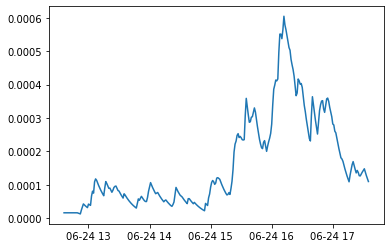

KDJ
                             K          D           J
time                                                 
2020-06-24 12:36:00  33.333333  44.444444   11.111111
2020-06-24 12:37:00  22.222222  37.037037   -7.407407
2020-06-24 12:38:00  14.814815  29.629630  -14.814815
2020-06-24 12:39:00   9.876543  23.045267  -16.460905
2020-06-24 12:40:00   6.584362  17.558299  -15.363512
...                        ...        ...         ...
2020-06-24 17:31:00  20.382678  22.147716   16.852602
2020-06-24 17:32:00  31.537170  25.277534   44.056442
2020-06-24 17:33:00  42.236901  30.930656   64.849391
2020-06-24 17:34:00  49.370055  37.077123   73.955921
2020-06-24 17:35:00  66.246704  46.800316  105.139478

[300 rows x 3 columns]


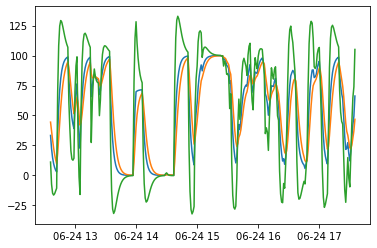

MACD
                         MACD  signal_line  histogram
time                                                 
2020-06-24 12:36:00  0.000000     0.000000   0.000000
2020-06-24 12:37:00  0.000000     0.000000   0.000000
2020-06-24 12:38:00  0.000000     0.000000   0.000000
2020-06-24 12:39:00  0.000000     0.000000   0.000000
2020-06-24 12:40:00  0.000000     0.000000   0.000000
...                       ...          ...        ...
2020-06-24 17:31:00 -0.000018     0.000038  -0.000056
2020-06-24 17:32:00 -0.000020     0.000027  -0.000046
2020-06-24 17:33:00 -0.000021     0.000017  -0.000038
2020-06-24 17:34:00 -0.000022     0.000010  -0.000031
2020-06-24 17:35:00 -0.000022     0.000003  -0.000025

[300 rows x 3 columns]


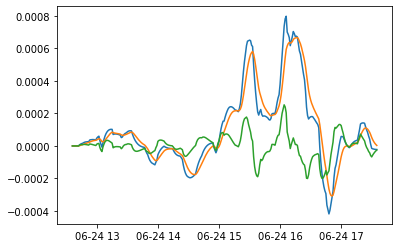

RSI_12
time
2020-06-24 12:36:00          NaN
2020-06-24 12:37:00          NaN
2020-06-24 12:38:00          NaN
2020-06-24 12:39:00          NaN
2020-06-24 12:40:00          NaN
                         ...    
2020-06-24 17:31:00    46.331263
2020-06-24 17:32:00    46.331263
2020-06-24 17:33:00    46.331263
2020-06-24 17:34:00    46.331263
2020-06-24 17:35:00    46.331263
Name: close, Length: 300, dtype: float64


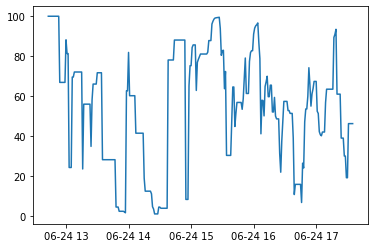

RSI_6
time
2020-06-24 12:36:00          NaN
2020-06-24 12:37:00          NaN
2020-06-24 12:38:00          NaN
2020-06-24 12:39:00          NaN
2020-06-24 12:40:00          NaN
                         ...    
2020-06-24 17:31:00    56.510667
2020-06-24 17:32:00    56.510667
2020-06-24 17:33:00    56.510667
2020-06-24 17:34:00    56.510667
2020-06-24 17:35:00    56.510667
Name: close, Length: 300, dtype: float64


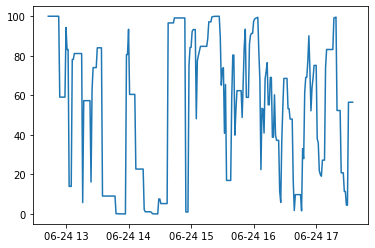

average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-24 13:02:00  0.778537  0.675500  1.457004
2020-06-24 13:03:00  0.716322  0.339772  0.732864
2020-06-24 13:04:00  0.664418  0.241343  0.520560
2020-06-24 13:05:00  0.629796  1.209032  0.484821
2020-06-24 13:06:00  0.600609  0.721981  0.289514
...                       ...       ...       ...
2020-06-24 17:30:00  0.379069  0.302688  0.448229
2020-06-24 17:31:00  0.354369  0.253940  0.376041
2020-06-24 17:32:00  0.332962  0.237010  0.350972
2020-06-24 17:33:00  0.314409  0.221210  0.327574
2020-06-24 17:34:00  0.298330  0.206462  0.305736

[273 rows x 3 columns]


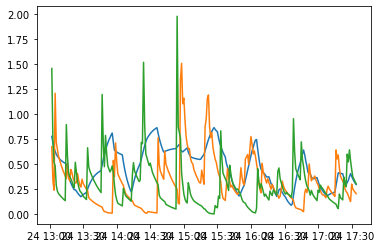

bollinger_bands
                        BB_up   BB_down  BB_width
time                                             
2020-06-24 12:55:00  0.067250  0.067250  0.000000
2020-06-24 12:56:00  0.067267  0.067260  0.000006
2020-06-24 12:57:00  0.067284  0.067270  0.000013
2020-06-24 12:58:00  0.067301  0.067280  0.000022
2020-06-24 12:59:00  0.067319  0.067289  0.000031
...                       ...       ...       ...
2020-06-24 17:31:00  0.071750  0.071599  0.000152
2020-06-24 17:32:00  0.071750  0.071599  0.000151
2020-06-24 17:33:00  0.071747  0.071602  0.000146
2020-06-24 17:34:00  0.071744  0.071605  0.000138
2020-06-24 17:35:00  0.071739  0.071610  0.000129

[281 rows x 3 columns]


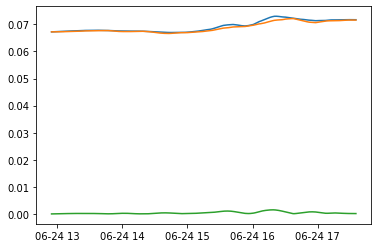

commodity_channel_index
time
2020-06-24 12:36:00         NaN
2020-06-24 12:37:00         NaN
2020-06-24 12:38:00         NaN
2020-06-24 12:39:00         NaN
2020-06-24 12:40:00         NaN
                         ...   
2020-06-24 17:31:00   -0.625699
2020-06-24 17:32:00   -0.625699
2020-06-24 17:33:00   -0.625699
2020-06-24 17:34:00   -0.625699
2020-06-24 17:35:00   -0.625699
Name: CCI, Length: 300, dtype: float64


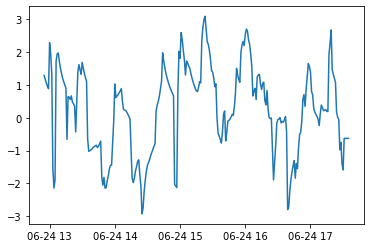

exponential_moving_average
                         open      high       low     close    volume
time                                                                 
2020-06-24 12:36:00  0.067120  0.067120  0.067120  0.067120  0.000000
2020-06-24 12:37:00  0.067120  0.067120  0.067120  0.067120  0.000000
2020-06-24 12:38:00  0.067120  0.067120  0.067120  0.067120  0.000000
2020-06-24 12:39:00  0.067120  0.067120  0.067120  0.067120  0.000000
2020-06-24 12:40:00  0.067120  0.067120  0.067120  0.067120  0.000000
...                       ...       ...       ...       ...       ...
2020-06-24 17:31:00  0.071484  0.071484  0.071467  0.071468  2.770674
2020-06-24 17:32:00  0.071515  0.071515  0.071509  0.071509  0.923558
2020-06-24 17:33:00  0.071525  0.071525  0.071523  0.071523  0.307853
2020-06-24 17:34:00  0.071528  0.071528  0.071528  0.071528  0.102618
2020-06-24 17:35:00  0.071529  0.071529  0.071529  0.071529  0.034206

[300 rows x 5 columns]


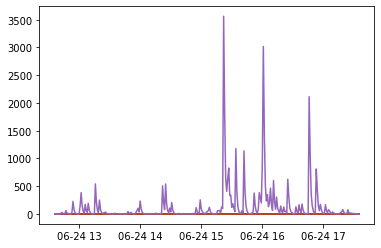

heikin_ashi
                         open     high       low     close
2020-06-24 12:36:00  0.067120  0.06712  0.044747  0.044747
2020-06-24 12:37:00  0.055933  0.06712  0.044747  0.044747
2020-06-24 12:38:00  0.050340  0.06712  0.044747  0.044747
2020-06-24 12:39:00  0.047543  0.06712  0.044747  0.044747
2020-06-24 12:40:00  0.046145  0.06712  0.044747  0.044747
...                       ...      ...       ...       ...
2020-06-24 17:31:00  0.047603  0.07153  0.047603  0.047687
2020-06-24 17:32:00  0.047645  0.07153  0.047645  0.047687
2020-06-24 17:33:00  0.047666  0.07153  0.047666  0.047687
2020-06-24 17:34:00  0.047676  0.07153  0.047676  0.047687
2020-06-24 17:35:00  0.047681  0.07153  0.047681  0.047687

[300 rows x 4 columns]


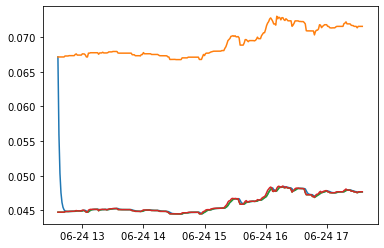

relative_volume_level
                       volume
time                         
2020-06-24 12:36:00       NaN
2020-06-24 12:37:00  0.000000
2020-06-24 12:38:00  0.000000
2020-06-24 12:39:00  0.000000
2020-06-24 12:40:00  0.000000
...                       ...
2020-06-24 17:31:00 -0.129146
2020-06-24 17:32:00 -0.109538
2020-06-24 17:33:00 -0.389099
2020-06-24 17:34:00 -0.054523
2020-06-24 17:35:00  0.000000

[300 rows x 1 columns]


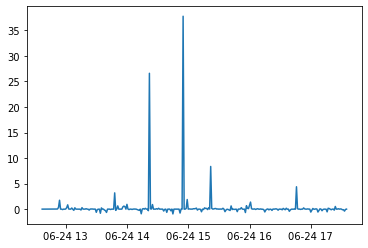

simple_moving_average
                         open      high       low     close        volume
time                                                                     
2020-06-24 12:36:00  0.067120  0.067120  0.067120  0.067120  0.000000e+00
2020-06-24 12:37:00  0.067120  0.067120  0.067120  0.067120  0.000000e+00
2020-06-24 12:38:00  0.067120  0.067120  0.067120  0.067120  0.000000e+00
2020-06-24 12:39:00  0.067120  0.067120  0.067120  0.067120  0.000000e+00
2020-06-24 12:40:00  0.067120  0.067120  0.067120  0.067120  0.000000e+00
...                       ...       ...       ...       ...           ...
2020-06-24 17:31:00  0.071425  0.071425  0.071425  0.071425  1.800000e+00
2020-06-24 17:32:00  0.071530  0.071530  0.071530  0.071530  8.500000e-01
2020-06-24 17:33:00  0.071530  0.071530  0.071530  0.071530  4.652945e-13
2020-06-24 17:34:00  0.071530  0.071530  0.071530  0.071530  4.652945e-13
2020-06-24 17:35:00  0.071530  0.071530  0.071530  0.071530  4.652945e-13

[300 rows x 5 c

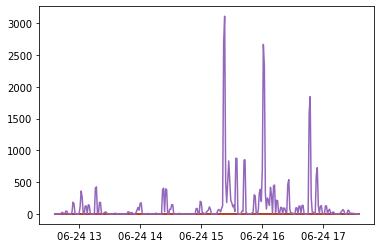

MACD_trigger
time
2020-06-24 12:36:00    0.0
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Name: histogram, Length: 300, dtype: float64


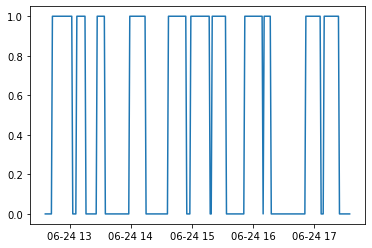

momentum_trigger
time
2020-06-24 12:36:00    0.0
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 300, dtype: float64


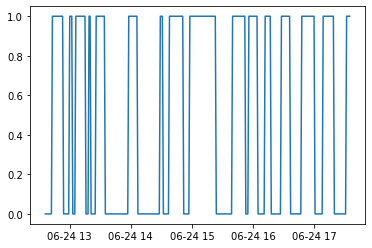

overtraded_trigger
time
2020-06-24 12:36:00    0.0
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Name: close, Length: 300, dtype: float64


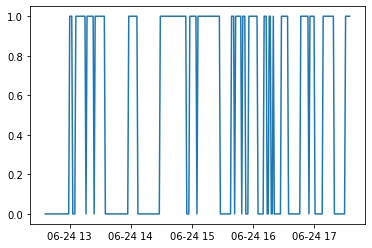

real_trigger
time
2020-06-24 12:36:00    0.0
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Length: 300, dtype: float64


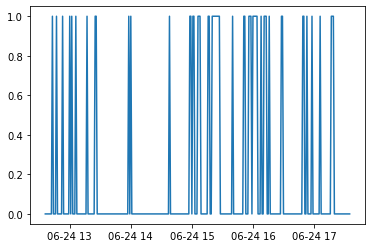

relative_volume_level_trigger
time
2020-06-24 12:36:00    0.0
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Name: volume, Length: 300, dtype: float64


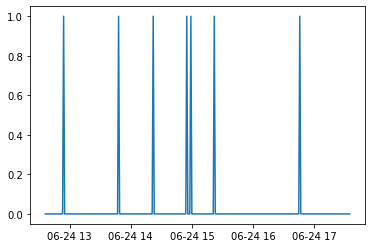

trend_strength_negative_trigger
time
2020-06-24 13:02:00    1.0
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    0.0
2020-06-24 13:06:00    0.0
                      ... 
2020-06-24 17:30:00    1.0
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
Length: 273, dtype: float64


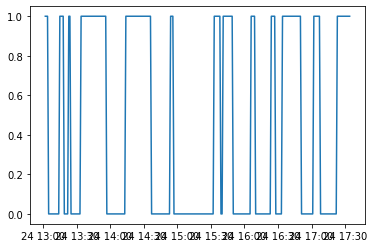

trend_strength_positive_trigger
time
2020-06-24 13:02:00    0.0
2020-06-24 13:03:00    0.0
2020-06-24 13:04:00    0.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
                      ... 
2020-06-24 17:30:00    0.0
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
Length: 273, dtype: float64


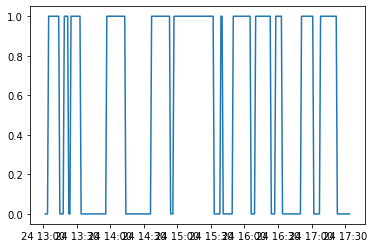

trend_strength_trigger
time
2020-06-24 13:02:00    1.0
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
                      ... 
2020-06-24 17:30:00    1.0
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
Name: ADX, Length: 273, dtype: float64


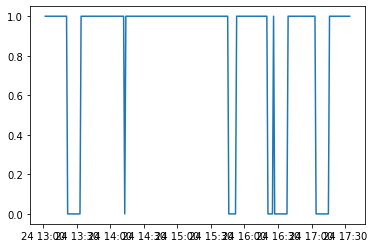

trend_trigger
2020-06-24 12:36:00    0.0
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 300, dtype: float64


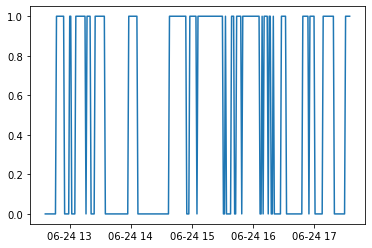

volatility_trigger
time
2020-06-24 12:36:00    0.0
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 300, dtype: float64


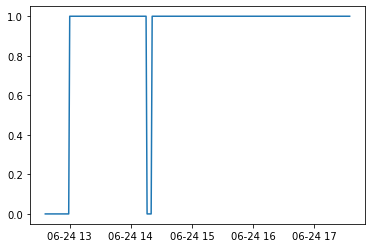

pair:  KAVABTC
interval:  1m
ATR
time
2020-06-24 12:37:00    2.167340e-07
2020-06-24 12:38:00    2.167340e-07
2020-06-24 12:39:00    2.167340e-07
2020-06-24 12:40:00    2.167340e-07
2020-06-24 12:41:00    2.167340e-07
                           ...     
2020-06-24 17:31:00    4.983827e-07
2020-06-24 17:32:00    4.892125e-07
2020-06-24 17:33:00    4.828402e-07
2020-06-24 17:34:00    4.590659e-07
2020-06-24 17:35:00    4.298469e-07
Length: 299, dtype: float64


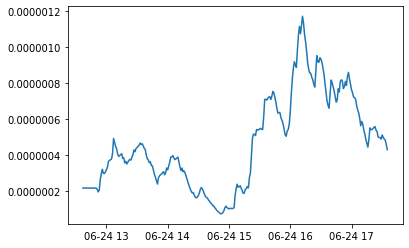

KDJ
                             K          D           J
time                                                 
2020-06-24 12:37:00  47.126437  49.042146   43.295019
2020-06-24 12:38:00  64.750958  54.278416   85.696041
2020-06-24 12:39:00  43.167305  50.574713   28.352490
2020-06-24 12:40:00  54.216800  51.788742   59.072916
2020-06-24 12:41:00  37.021726  46.866403   17.332372
...                        ...        ...         ...
2020-06-24 17:31:00  41.521555  39.271242   46.022179
2020-06-24 17:32:00  55.859731  44.800738   77.977715
2020-06-24 17:33:00  66.449442  52.016973   95.314381
2020-06-24 17:34:00  73.509250  59.181065  102.165620
2020-06-24 17:35:00  82.339500  66.900544  113.217413

[299 rows x 3 columns]


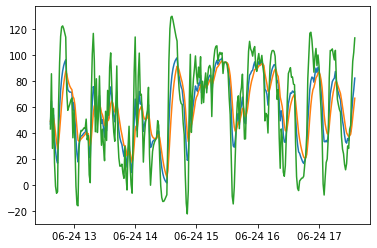

MACD
                             MACD   signal_line     histogram
time                                                         
2020-06-24 12:37:00  3.814103e-09  3.814103e-09  0.000000e+00
2020-06-24 12:38:00  3.814103e-09  3.814103e-09  0.000000e+00
2020-06-24 12:39:00 -6.923854e-09 -5.866991e-10 -6.337154e-09
2020-06-24 12:40:00 -1.167661e-09 -7.835019e-10 -3.841590e-10
2020-06-24 12:41:00 -9.157094e-09 -3.274456e-09 -5.882638e-09
...                           ...           ...           ...
2020-06-24 17:31:00 -2.080915e-08  6.259972e-08 -8.340887e-08
2020-06-24 17:32:00 -1.732723e-08  4.661433e-08 -6.394156e-08
2020-06-24 17:33:00 -1.200861e-08  3.488974e-08 -4.689835e-08
2020-06-24 17:34:00 -7.704748e-09  2.637084e-08 -3.407559e-08
2020-06-24 17:35:00 -1.054089e-09  2.088586e-08 -2.193995e-08

[299 rows x 3 columns]


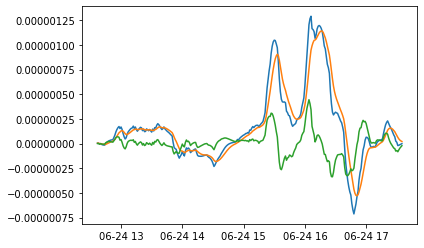

RSI_12
time
2020-06-24 12:37:00    100.000000
2020-06-24 12:38:00    100.000000
2020-06-24 12:39:00     27.488844
2020-06-24 12:40:00     56.216713
2020-06-24 12:41:00     38.744960
                          ...    
2020-06-24 17:31:00     32.343905
2020-06-24 17:32:00     50.982736
2020-06-24 17:33:00     52.239755
2020-06-24 17:34:00     52.239755
2020-06-24 17:35:00     54.416152
Name: close, Length: 299, dtype: float64


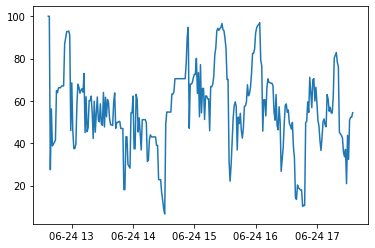

RSI_6
time
2020-06-24 12:37:00    100.000000
2020-06-24 12:38:00    100.000000
2020-06-24 12:39:00     24.243452
2020-06-24 12:40:00     58.193119
2020-06-24 12:41:00     36.274386
                          ...    
2020-06-24 17:31:00     29.298761
2020-06-24 17:32:00     57.662814
2020-06-24 17:33:00     59.501555
2020-06-24 17:34:00     59.501555
2020-06-24 17:35:00     63.628673
Name: close, Length: 299, dtype: float64


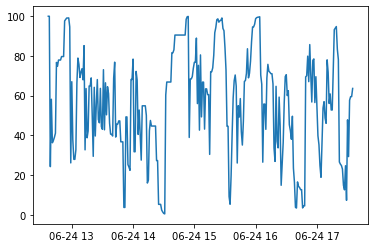

average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-24 13:03:00  0.385940  0.107550  0.246737
2020-06-24 13:04:00  0.339849  0.248268  0.211204
2020-06-24 13:05:00  0.379754  0.742976  0.180654
2020-06-24 13:06:00  0.413236  0.595053  0.144686
2020-06-24 13:07:00  0.441461  0.426505  0.103704
...                       ...       ...       ...
2020-06-24 17:30:00  0.360111  0.077342  0.310638
2020-06-24 17:31:00  0.387424  0.076901  0.276632
2020-06-24 17:32:00  0.404053  0.078799  0.244242
2020-06-24 17:33:00  0.418465  0.069194  0.214470
2020-06-24 17:34:00  0.422286  0.074691  0.195500

[272 rows x 3 columns]


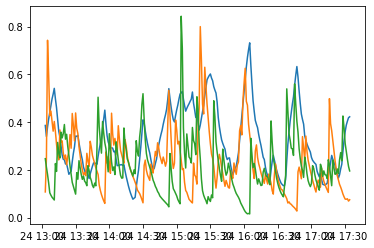

bollinger_bands
                        BB_up   BB_down      BB_width
time                                                 
2020-06-24 12:56:00  0.000116  0.000116  0.000000e+00
2020-06-24 12:57:00  0.000116  0.000116  2.079543e-08
2020-06-24 12:58:00  0.000116  0.000116  4.196926e-08
2020-06-24 12:59:00  0.000116  0.000116  6.566380e-08
2020-06-24 13:00:00  0.000116  0.000116  9.475292e-08
...                       ...       ...           ...
2020-06-24 17:31:00  0.000123  0.000123  2.369753e-07
2020-06-24 17:32:00  0.000123  0.000123  2.364065e-07
2020-06-24 17:33:00  0.000123  0.000123  2.322758e-07
2020-06-24 17:34:00  0.000123  0.000123  2.258338e-07
2020-06-24 17:35:00  0.000123  0.000123  2.189878e-07

[280 rows x 3 columns]


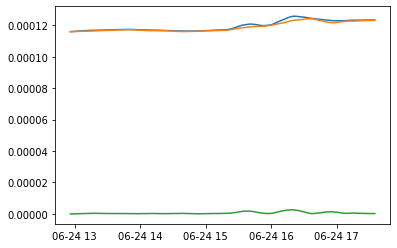

commodity_channel_index
time
2020-06-24 12:37:00         NaN
2020-06-24 12:38:00         NaN
2020-06-24 12:39:00         NaN
2020-06-24 12:40:00         NaN
2020-06-24 12:41:00         NaN
                         ...   
2020-06-24 17:31:00   -1.037540
2020-06-24 17:32:00   -0.630787
2020-06-24 17:33:00   -0.308415
2020-06-24 17:34:00   -0.208932
2020-06-24 17:35:00   -0.180109
Name: CCI, Length: 299, dtype: float64


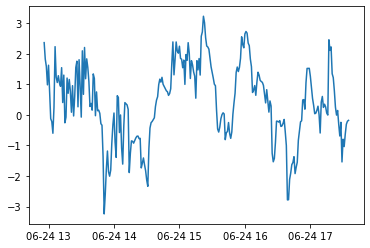

exponential_moving_average
                         open      high       low     close       volume
time                                                                    
2020-06-24 12:37:00  0.000116  0.000116  0.000116  0.000116  2978.000000
2020-06-24 12:38:00  0.000116  0.000116  0.000116  0.000116   770.750000
2020-06-24 12:39:00  0.000116  0.000116  0.000116  0.000116   296.692308
2020-06-24 12:40:00  0.000116  0.000116  0.000116  0.000116   672.875000
2020-06-24 12:41:00  0.000116  0.000116  0.000116  0.000116   426.611570
...                       ...       ...       ...       ...          ...
2020-06-24 17:31:00  0.000123  0.000123  0.000123  0.000123  1157.760335
2020-06-24 17:32:00  0.000123  0.000123  0.000123  0.000123  1959.920112
2020-06-24 17:33:00  0.000123  0.000123  0.000123  0.000123  1609.306704
2020-06-24 17:34:00  0.000123  0.000123  0.000123  0.000123   641.768901
2020-06-24 17:35:00  0.000123  0.000123  0.000123  0.000123  1185.256300

[299 rows x 5 columns]


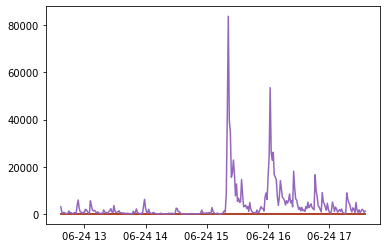

heikin_ashi
                         open      high       low     close
2020-06-24 12:37:00  0.000116  0.000116  0.000077  0.000077
2020-06-24 12:38:00  0.000097  0.000116  0.000077  0.000077
2020-06-24 12:39:00  0.000087  0.000116  0.000077  0.000077
2020-06-24 12:40:00  0.000082  0.000116  0.000077  0.000077
2020-06-24 12:41:00  0.000080  0.000116  0.000077  0.000077
...                       ...       ...       ...       ...
2020-06-24 17:31:00  0.000082  0.000123  0.000082  0.000082
2020-06-24 17:32:00  0.000082  0.000123  0.000082  0.000082
2020-06-24 17:33:00  0.000082  0.000123  0.000082  0.000082
2020-06-24 17:34:00  0.000082  0.000123  0.000082  0.000082
2020-06-24 17:35:00  0.000082  0.000123  0.000082  0.000082

[299 rows x 4 columns]


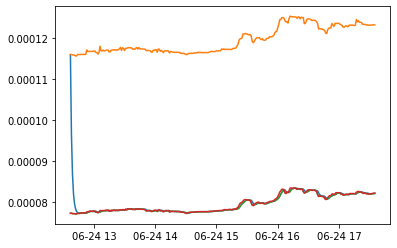

relative_volume_level
                       volume
time                         
2020-06-24 12:37:00       NaN
2020-06-24 12:38:00  0.000000
2020-06-24 12:39:00  0.000000
2020-06-24 12:40:00  0.000000
2020-06-24 12:41:00  0.000000
...                       ...
2020-06-24 17:31:00 -0.284444
2020-06-24 17:32:00 -0.089691
2020-06-24 17:33:00 -0.094470
2020-06-24 17:34:00 -0.142252
2020-06-24 17:35:00  0.037804

[299 rows x 1 columns]


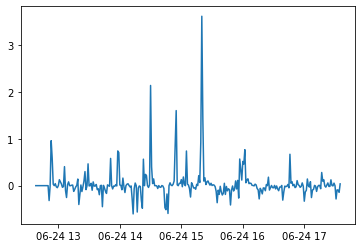

simple_moving_average
                         open      high       low     close  volume
time                                                               
2020-06-24 12:37:00  0.000116  0.000116  0.000116  0.000116  1506.5
2020-06-24 12:38:00  0.000116  0.000116  0.000116  0.000116  1506.5
2020-06-24 12:39:00  0.000116  0.000116  0.000116  0.000116    60.5
2020-06-24 12:40:00  0.000116  0.000116  0.000116  0.000116   470.0
2020-06-24 12:41:00  0.000116  0.000116  0.000116  0.000116   579.5
...                       ...       ...       ...       ...     ...
2020-06-24 17:31:00  0.000123  0.000123  0.000123  0.000123   730.0
2020-06-24 17:32:00  0.000123  0.000123  0.000123  0.000123  1901.0
2020-06-24 17:33:00  0.000123  0.000123  0.000123  0.000123  1897.5
2020-06-24 17:34:00  0.000123  0.000123  0.000123  0.000123   796.0
2020-06-24 17:35:00  0.000123  0.000123  0.000123  0.000123   807.5

[299 rows x 5 columns]


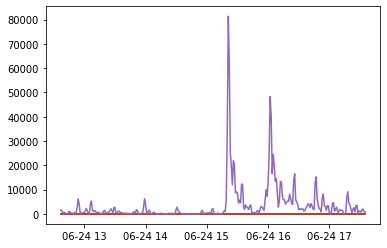

MACD_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Name: histogram, Length: 299, dtype: float64


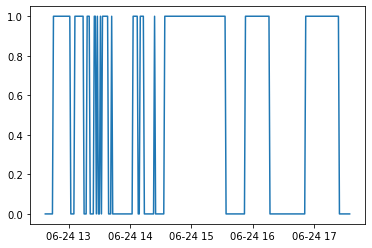

momentum_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    1.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 299, dtype: float64


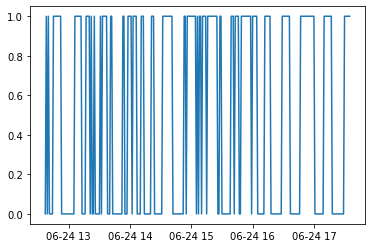

overtraded_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Name: close, Length: 299, dtype: float64


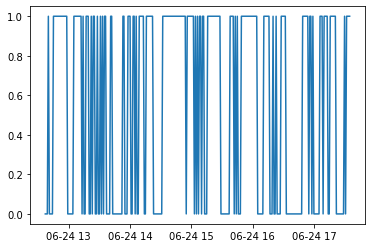

real_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    1.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 299, dtype: float64


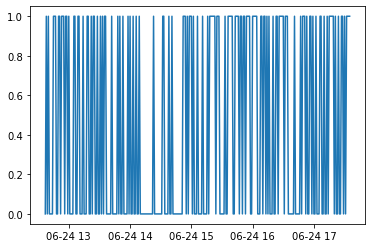

relative_volume_level_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Name: volume, Length: 299, dtype: float64


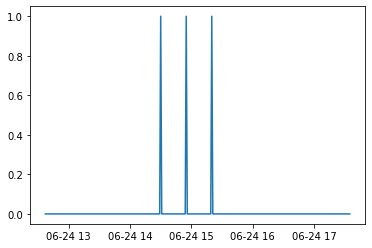

trend_strength_negative_trigger
time
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    0.0
2020-06-24 13:05:00    0.0
2020-06-24 13:06:00    0.0
2020-06-24 13:07:00    0.0
                      ... 
2020-06-24 17:30:00    1.0
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
Length: 272, dtype: float64


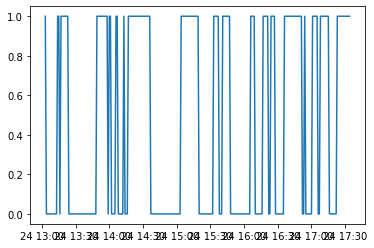

trend_strength_positive_trigger
time
2020-06-24 13:03:00    0.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
2020-06-24 13:07:00    1.0
                      ... 
2020-06-24 17:30:00    0.0
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
Length: 272, dtype: float64


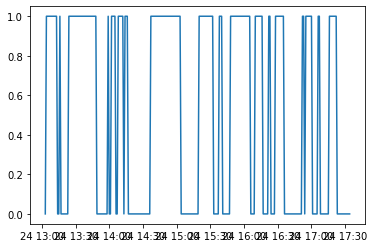

trend_strength_trigger
time
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
2020-06-24 13:07:00    1.0
                      ... 
2020-06-24 17:30:00    1.0
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
Name: ADX, Length: 272, dtype: float64


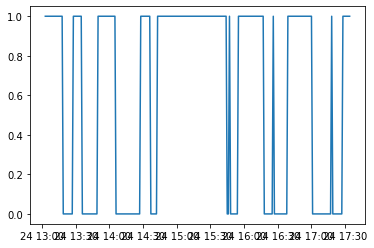

trend_trigger
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 299, dtype: float64


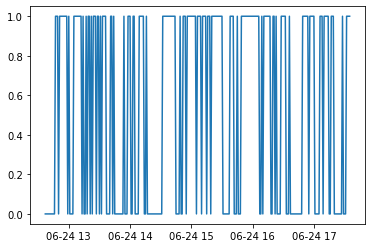

volatility_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 299, dtype: float64


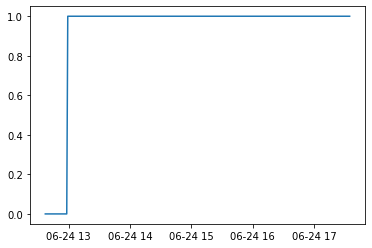

pair:  KAVAUSDT
interval:  1m
ATR
time
2020-06-24 12:37:00    0.001304
2020-06-24 12:38:00    0.001304
2020-06-24 12:39:00    0.001304
2020-06-24 12:40:00    0.001304
2020-06-24 12:41:00    0.001304
                         ...   
2020-06-24 17:31:00    0.003751
2020-06-24 17:32:00    0.003604
2020-06-24 17:33:00    0.003861
2020-06-24 17:34:00    0.003749
2020-06-24 17:35:00    0.003624
Length: 299, dtype: float64


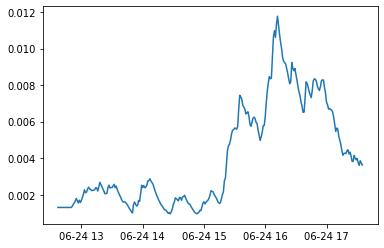

KDJ
                             K          D           J
time                                                 
2020-06-24 12:37:00  33.333333  44.444444   11.111111
2020-06-24 12:38:00  55.555556  48.148148   70.370370
2020-06-24 12:39:00  70.370370  55.555556  100.000000
2020-06-24 12:40:00  46.913580  52.674897   35.390947
2020-06-24 12:41:00  51.158761  52.169518   49.137246
...                        ...        ...         ...
2020-06-24 17:31:00  36.966019  34.903370   41.091316
2020-06-24 17:32:00  33.578721  34.461820   31.812521
2020-06-24 17:33:00  49.533580  39.485740   69.629260
2020-06-24 17:34:00  65.668435  48.213305  100.578694
2020-06-24 17:35:00  74.305272  56.910628  109.094562

[299 rows x 3 columns]


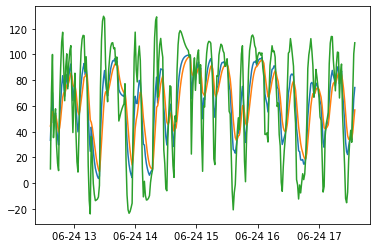

MACD
                         MACD  signal_line  histogram
time                                                 
2020-06-24 12:37:00  0.000049     0.000049   0.000000
2020-06-24 12:38:00  0.000049     0.000049   0.000000
2020-06-24 12:39:00  0.000063     0.000055   0.000008
2020-06-24 12:40:00 -0.000138    -0.000011  -0.000128
2020-06-24 12:41:00 -0.000109    -0.000040  -0.000069
...                       ...          ...        ...
2020-06-24 17:31:00  0.000440     0.000995  -0.000555
2020-06-24 17:32:00  0.000226     0.000841  -0.000615
2020-06-24 17:33:00  0.000479     0.000769  -0.000290
2020-06-24 17:34:00  0.000800     0.000775   0.000025
2020-06-24 17:35:00  0.000978     0.000815   0.000162

[299 rows x 3 columns]


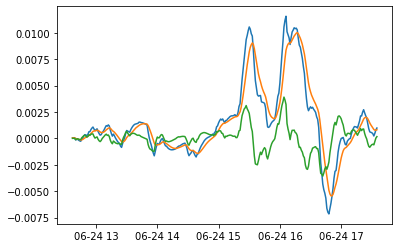

RSI_12
time
2020-06-24 12:37:00    100.000000
2020-06-24 12:38:00    100.000000
2020-06-24 12:39:00    100.000000
2020-06-24 12:40:00     21.685656
2020-06-24 12:41:00     49.637041
                          ...    
2020-06-24 17:31:00     46.817307
2020-06-24 17:32:00     39.137879
2020-06-24 17:33:00     62.085956
2020-06-24 17:34:00     66.563170
2020-06-24 17:35:00     62.227041
Name: close, Length: 299, dtype: float64


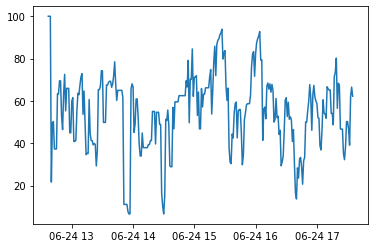

RSI_6
time
2020-06-24 12:37:00    100.000000
2020-06-24 12:38:00    100.000000
2020-06-24 12:39:00    100.000000
2020-06-24 12:40:00     16.480310
2020-06-24 12:41:00     50.904266
                          ...    
2020-06-24 17:31:00     47.946834
2020-06-24 17:32:00     30.621869
2020-06-24 17:33:00     73.103808
2020-06-24 17:34:00     78.613047
2020-06-24 17:35:00     68.766769
Name: close, Length: 299, dtype: float64


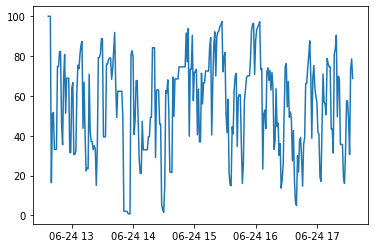

average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-24 13:03:00  0.228065  0.222824  0.380431
2020-06-24 13:04:00  0.195355  0.361008  0.352859
2020-06-24 13:05:00  0.193307  0.434691  0.301105
2020-06-24 13:06:00  0.191589  0.349551  0.242129
2020-06-24 13:07:00  0.203360  0.349539  0.199554
...                       ...       ...       ...
2020-06-24 17:30:00  0.261194  0.139580  0.214949
2020-06-24 17:31:00  0.253520  0.299180  0.197945
2020-06-24 17:32:00  0.246869  0.269827  0.178524
2020-06-24 17:33:00  0.255142  0.273547  0.144428
2020-06-24 17:34:00  0.230927  0.244124  0.210683

[272 rows x 3 columns]


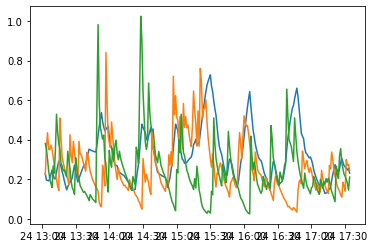

bollinger_bands
                        BB_up   BB_down  BB_width
time                                             
2020-06-24 12:56:00  1.080210  1.080210  0.000000
2020-06-24 12:57:00  1.080583  1.080447  0.000136
2020-06-24 12:58:00  1.080620  1.080430  0.000191
2020-06-24 12:59:00  1.080650  1.080420  0.000231
2020-06-24 13:00:00  1.081184  1.080786  0.000398
...                       ...       ...       ...
2020-06-24 17:31:00  1.146731  1.143239  0.003492
2020-06-24 17:32:00  1.146565  1.143185  0.003380
2020-06-24 17:33:00  1.146652  1.143408  0.003244
2020-06-24 17:34:00  1.146902  1.143798  0.003105
2020-06-24 17:35:00  1.147136  1.144124  0.003011

[280 rows x 3 columns]


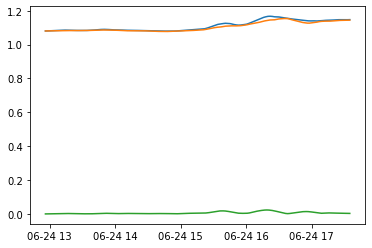

commodity_channel_index
time
2020-06-24 12:37:00         NaN
2020-06-24 12:38:00         NaN
2020-06-24 12:39:00         NaN
2020-06-24 12:40:00         NaN
2020-06-24 12:41:00         NaN
                         ...   
2020-06-24 17:31:00   -0.463477
2020-06-24 17:32:00   -0.394600
2020-06-24 17:33:00    0.587206
2020-06-24 17:34:00    0.876772
2020-06-24 17:35:00    0.450291
Name: CCI, Length: 299, dtype: float64


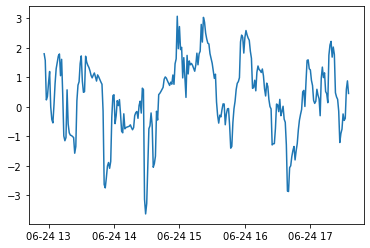

exponential_moving_average
                         open      high       low     close       volume
time                                                                    
2020-06-24 12:37:00  1.078900  1.078900  1.078800  1.078800  3000.000000
2020-06-24 12:38:00  1.078750  1.080475  1.077900  1.080450   809.842500
2020-06-24 12:39:00  1.080308  1.080838  1.080046  1.080831   383.739231
2020-06-24 12:40:00  1.080775  1.080947  1.076842  1.077097  3443.865750
2020-06-24 12:41:00  1.079386  1.079443  1.078086  1.078170  1140.603471
...                       ...       ...       ...       ...          ...
2020-06-24 17:31:00  1.143465  1.143659  1.143254  1.143633  1154.448228
2020-06-24 17:32:00  1.143488  1.146753  1.141818  1.142411  5071.569409
2020-06-24 17:33:00  1.145429  1.146984  1.144873  1.145537  2753.249803
2020-06-24 17:34:00  1.146276  1.148128  1.146091  1.147646   989.549934
2020-06-24 17:35:00  1.147359  1.148376  1.144964  1.147815  1279.463311

[299 rows x 5 columns]


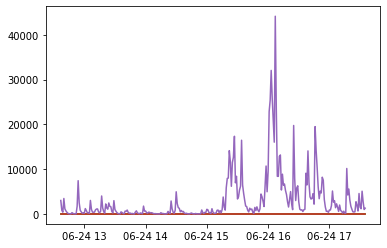

heikin_ashi
                         open    high       low     close
2020-06-24 12:37:00  1.078900  1.0789  0.719233  0.719233
2020-06-24 12:38:00  0.899067  1.0810  0.719717  0.719717
2020-06-24 12:39:00  0.809392  1.0810  0.720667  0.720667
2020-06-24 12:40:00  0.765029  1.0810  0.718767  0.718767
2020-06-24 12:41:00  0.741898  1.0787  0.719133  0.719133
...                       ...     ...       ...       ...
2020-06-24 17:31:00  0.762162  1.1435  0.762162  0.762333
2020-06-24 17:32:00  0.762248  1.1483  0.762248  0.762450
2020-06-24 17:33:00  0.762349  1.1471  0.762349  0.764500
2020-06-24 17:34:00  0.763424  1.1487  0.763424  0.765133
2020-06-24 17:35:00  0.764279  1.1485  0.764279  0.764783

[299 rows x 4 columns]


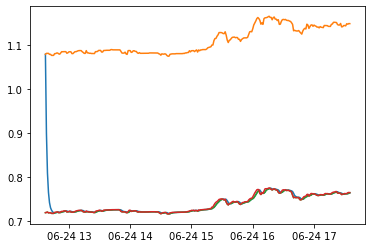

relative_volume_level
                       volume
time                         
2020-06-24 12:37:00       NaN
2020-06-24 12:38:00  0.000000
2020-06-24 12:39:00  0.000000
2020-06-24 12:40:00  0.000000
2020-06-24 12:41:00  0.000000
...                       ...
2020-06-24 17:31:00 -0.361637
2020-06-24 17:32:00  0.230929
2020-06-24 17:33:00 -0.150347
2020-06-24 17:34:00 -0.066230
2020-06-24 17:35:00  0.015705

[299 rows x 1 columns]


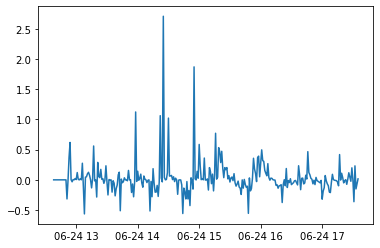

simple_moving_average
                        open     high      low    close    volume
time                                                             
2020-06-24 12:37:00  1.07880  1.07995  1.07820  1.07990  1539.895
2020-06-24 12:38:00  1.07880  1.07995  1.07820  1.07990  1539.895
2020-06-24 12:39:00  1.07985  1.08100  1.07930  1.08100   137.075
2020-06-24 12:40:00  1.08100  1.08100  1.07815  1.07815  2555.810
2020-06-24 12:41:00  1.07985  1.07985  1.07700  1.07700  2460.225
...                      ...      ...      ...      ...       ...
2020-06-24 17:31:00  1.14385  1.14385  1.14385  1.14385   486.875
2020-06-24 17:32:00  1.14350  1.14590  1.14230  1.14265  4000.530
2020-06-24 17:33:00  1.14495  1.14770  1.14375  1.14445  4312.110
2020-06-24 17:34:00  1.14655  1.14790  1.14655  1.14790   850.895
2020-06-24 17:35:00  1.14730  1.14860  1.14555  1.14830   766.060

[299 rows x 5 columns]


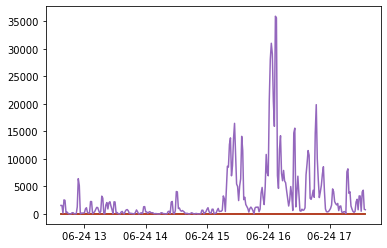

MACD_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Name: histogram, Length: 299, dtype: float64


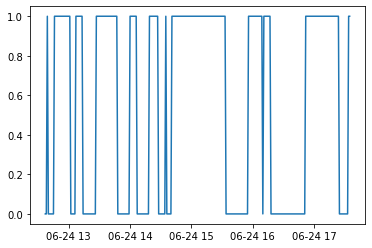

momentum_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    1.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 299, dtype: float64


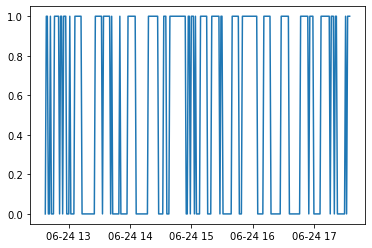

overtraded_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    1.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Name: close, Length: 299, dtype: float64


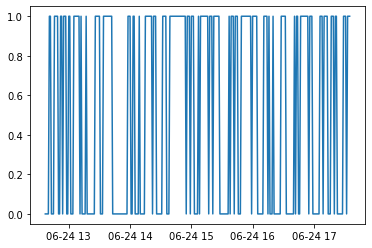

real_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    1.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    0.0
Length: 299, dtype: float64


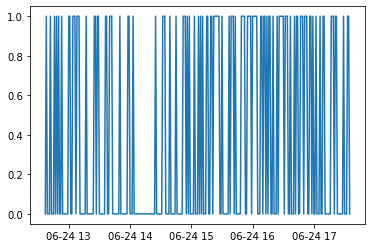

relative_volume_level_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Name: volume, Length: 299, dtype: float64


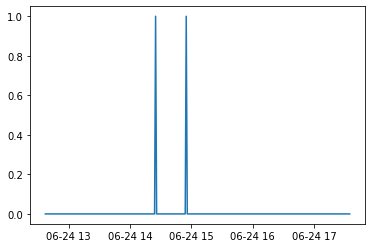

trend_strength_negative_trigger
time
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    0.0
2020-06-24 13:05:00    0.0
2020-06-24 13:06:00    0.0
2020-06-24 13:07:00    0.0
                      ... 
2020-06-24 17:30:00    1.0
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
Length: 272, dtype: float64


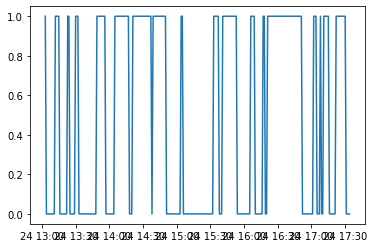

trend_strength_positive_trigger
time
2020-06-24 13:03:00    0.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
2020-06-24 13:07:00    1.0
                      ... 
2020-06-24 17:30:00    0.0
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
Length: 272, dtype: float64


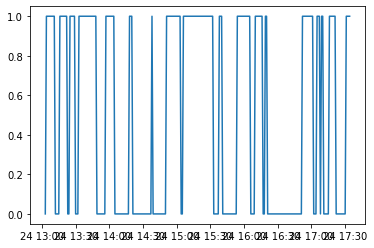

trend_strength_trigger
time
2020-06-24 13:03:00    0.0
2020-06-24 13:04:00    0.0
2020-06-24 13:05:00    0.0
2020-06-24 13:06:00    0.0
2020-06-24 13:07:00    0.0
                      ... 
2020-06-24 17:30:00    1.0
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    0.0
Name: ADX, Length: 272, dtype: float64


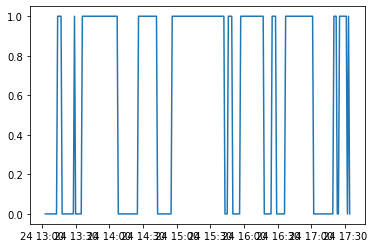

trend_trigger
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 299, dtype: float64


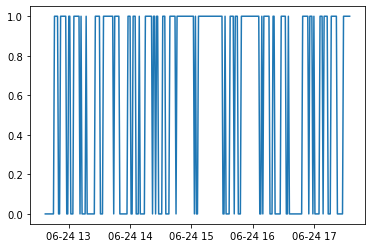

volatility_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 299, dtype: float64


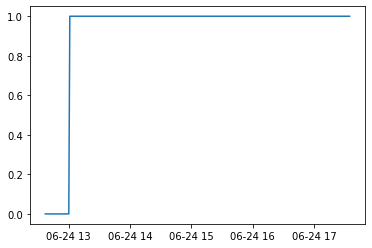

pair:  BNBBTC
interval:  1m
ATR
time
2020-06-24 12:37:00    4.937608e-07
2020-06-24 12:38:00    4.937608e-07
2020-06-24 12:39:00    4.937608e-07
2020-06-24 12:40:00    4.937608e-07
2020-06-24 12:41:00    4.937608e-07
                           ...     
2020-06-24 17:31:00    7.305119e-07
2020-06-24 17:32:00    7.283325e-07
2020-06-24 17:33:00    7.334516e-07
2020-06-24 17:34:00    7.382050e-07
2020-06-24 17:35:00    7.711904e-07
Length: 299, dtype: float64


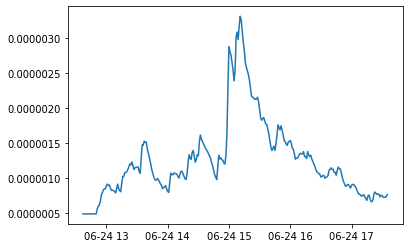

KDJ
                             K          D           J
time                                                 
2020-06-24 12:37:00  55.555556  51.851852   62.962963
2020-06-24 12:38:00  37.037037  46.913580   17.283951
2020-06-24 12:39:00  35.802469  43.209877   20.987654
2020-06-24 12:40:00  46.090535  44.170096   49.931413
2020-06-24 12:41:00  36.282579  41.540924   25.765889
...                        ...        ...         ...
2020-06-24 17:31:00  87.747339  81.405925  100.430165
2020-06-24 17:32:00  86.568401  83.126751   93.451702
2020-06-24 17:33:00  87.536829  84.596777   93.416933
2020-06-24 17:34:00  83.691219  84.294924   82.483809
2020-06-24 17:35:00  81.881103  83.490317   78.662674

[299 rows x 3 columns]


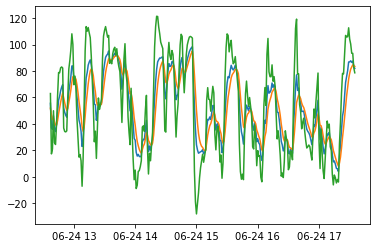

MACD
                             MACD   signal_line     histogram
time                                                         
2020-06-24 12:37:00 -4.487179e-09 -4.487179e-09  0.000000e+00
2020-06-24 12:38:00 -4.487179e-09 -4.487179e-09  0.000000e+00
2020-06-24 12:39:00 -2.616563e-09 -3.720534e-09  1.103970e-09
2020-06-24 12:40:00  1.908817e-09 -1.813572e-09  3.722389e-09
2020-06-24 12:41:00 -1.158927e-08 -4.721620e-09 -6.867646e-09
...                           ...           ...           ...
2020-06-24 17:31:00  3.645708e-07  7.649995e-08  2.880709e-07
2020-06-24 17:32:00  4.090337e-07  1.430067e-07  2.660270e-07
2020-06-24 17:33:00  4.471852e-07  2.038424e-07  2.433428e-07
2020-06-24 17:34:00  5.198431e-07  2.670425e-07  2.528005e-07
2020-06-24 17:35:00  5.788218e-07  3.293984e-07  2.494234e-07

[299 rows x 3 columns]


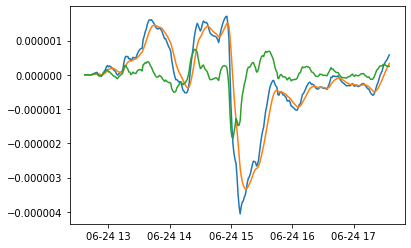

RSI_12
time
2020-06-24 12:37:00     0.000000
2020-06-24 12:38:00     0.000000
2020-06-24 12:39:00    37.145564
2020-06-24 12:40:00    56.319769
2020-06-24 12:41:00    23.062917
                         ...    
2020-06-24 17:31:00    75.842944
2020-06-24 17:32:00    75.842944
2020-06-24 17:33:00    77.383619
2020-06-24 17:34:00    84.426271
2020-06-24 17:35:00    85.325996
Name: close, Length: 299, dtype: float64


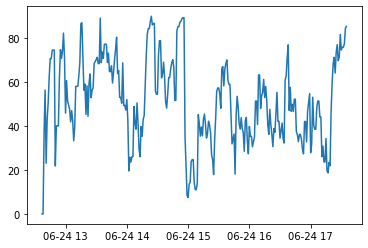

RSI_6
time
2020-06-24 12:37:00     0.000000
2020-06-24 12:38:00     0.000000
2020-06-24 12:39:00    41.179279
2020-06-24 12:40:00    62.688488
2020-06-24 12:41:00    20.569412
                         ...    
2020-06-24 17:31:00    78.179481
2020-06-24 17:32:00    78.179481
2020-06-24 17:33:00    81.672872
2020-06-24 17:34:00    92.183705
2020-06-24 17:35:00    93.105943
Name: close, Length: 299, dtype: float64


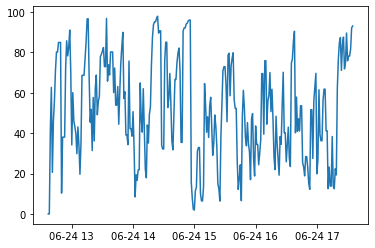

average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-24 13:03:00  0.239877  0.144498  0.186526
2020-06-24 13:04:00  0.261817  0.131133  0.295447
2020-06-24 13:05:00  0.280121  0.117877  0.265581
2020-06-24 13:06:00  0.295478  0.101314  0.228265
2020-06-24 13:07:00  0.308425  0.088657  0.199747
...                       ...       ...       ...
2020-06-24 17:30:00  0.566916  0.311934  0.095936
2020-06-24 17:31:00  0.564918  0.298004  0.086038
2020-06-24 17:32:00  0.563187  0.259043  0.074789
2020-06-24 17:33:00  0.584839  0.404726  0.064365
2020-06-24 17:34:00  0.603604  0.348504  0.055424

[272 rows x 3 columns]


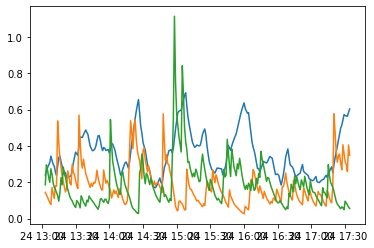

bollinger_bands
                        BB_up   BB_down      BB_width
time                                                 
2020-06-24 12:56:00  0.001725  0.001725  0.000000e+00
2020-06-24 12:57:00  0.001725  0.001725  2.459675e-08
2020-06-24 12:58:00  0.001725  0.001725  7.232238e-08
2020-06-24 12:59:00  0.001725  0.001725  1.234365e-07
2020-06-24 13:00:00  0.001726  0.001725  1.622368e-07
...                       ...       ...           ...
2020-06-24 17:31:00  0.001719  0.001719  4.960040e-07
2020-06-24 17:32:00  0.001719  0.001719  4.457991e-07
2020-06-24 17:33:00  0.001719  0.001719  4.211747e-07
2020-06-24 17:34:00  0.001719  0.001719  4.439725e-07
2020-06-24 17:35:00  0.001720  0.001719  5.113861e-07

[280 rows x 3 columns]


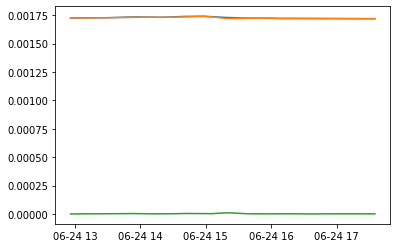

commodity_channel_index
time
2020-06-24 12:37:00         NaN
2020-06-24 12:38:00         NaN
2020-06-24 12:39:00         NaN
2020-06-24 12:40:00         NaN
2020-06-24 12:41:00         NaN
                         ...   
2020-06-24 17:31:00    1.543619
2020-06-24 17:32:00    1.400834
2020-06-24 17:33:00    1.381484
2020-06-24 17:34:00    1.659822
2020-06-24 17:35:00    1.530841
Name: CCI, Length: 299, dtype: float64


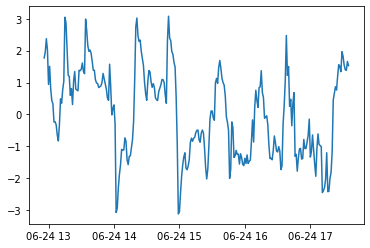

exponential_moving_average
                         open      high       low     close      volume
time                                                                   
2020-06-24 12:37:00  0.001725  0.001725  0.001725  0.001725   69.170000
2020-06-24 12:38:00  0.001725  0.001725  0.001725  0.001725  157.010000
2020-06-24 12:39:00  0.001725  0.001725  0.001725  0.001725  136.081538
2020-06-24 12:40:00  0.001725  0.001725  0.001725  0.001725   94.736750
2020-06-24 12:41:00  0.001725  0.001725  0.001725  0.001725   57.519091
...                       ...       ...       ...       ...         ...
2020-06-24 17:31:00  0.001721  0.001721  0.001720  0.001721  506.082064
2020-06-24 17:32:00  0.001721  0.001721  0.001720  0.001721  345.600688
2020-06-24 17:33:00  0.001721  0.001721  0.001720  0.001721  385.213563
2020-06-24 17:34:00  0.001721  0.001722  0.001721  0.001721  750.277854
2020-06-24 17:35:00  0.001721  0.001722  0.001721  0.001721  580.839285

[299 rows x 5 columns]


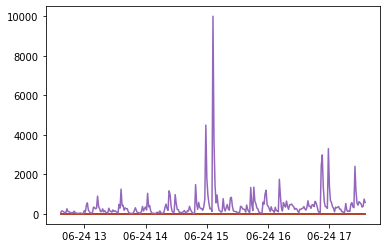

heikin_ashi
                         open      high       low     close
2020-06-24 12:37:00  0.001725  0.001725  0.001150  0.001150
2020-06-24 12:38:00  0.001438  0.001725  0.001150  0.001150
2020-06-24 12:39:00  0.001294  0.001725  0.001150  0.001150
2020-06-24 12:40:00  0.001222  0.001725  0.001150  0.001150
2020-06-24 12:41:00  0.001186  0.001725  0.001150  0.001150
...                       ...       ...       ...       ...
2020-06-24 17:31:00  0.001147  0.001721  0.001147  0.001147
2020-06-24 17:32:00  0.001147  0.001721  0.001147  0.001147
2020-06-24 17:33:00  0.001147  0.001721  0.001147  0.001147
2020-06-24 17:34:00  0.001147  0.001722  0.001147  0.001147
2020-06-24 17:35:00  0.001147  0.001722  0.001147  0.001148

[299 rows x 4 columns]


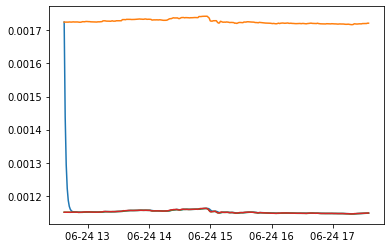

relative_volume_level
                       volume
time                         
2020-06-24 12:37:00       NaN
2020-06-24 12:38:00  0.000000
2020-06-24 12:39:00  0.000000
2020-06-24 12:40:00  0.000000
2020-06-24 12:41:00  0.000000
...                       ...
2020-06-24 17:31:00  0.055342
2020-06-24 17:32:00  0.020873
2020-06-24 17:33:00  0.026619
2020-06-24 17:34:00  0.091573
2020-06-24 17:35:00 -0.018428

[299 rows x 1 columns]


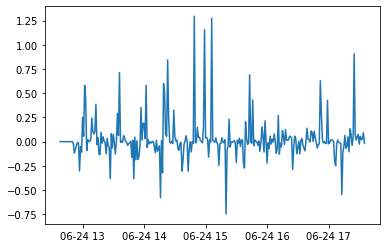

simple_moving_average
                         open      high       low     close   volume
time                                                                
2020-06-24 12:37:00  0.001725  0.001725  0.001725  0.001725  127.730
2020-06-24 12:38:00  0.001725  0.001725  0.001725  0.001725  127.730
2020-06-24 12:39:00  0.001725  0.001725  0.001725  0.001725  156.535
2020-06-24 12:40:00  0.001725  0.001725  0.001725  0.001725  100.805
2020-06-24 12:41:00  0.001725  0.001725  0.001725  0.001725   56.985
...                       ...       ...       ...       ...      ...
2020-06-24 17:31:00  0.001721  0.001721  0.001720  0.001721  504.040
2020-06-24 17:32:00  0.001721  0.001721  0.001720  0.001721  372.280
2020-06-24 17:33:00  0.001721  0.001721  0.001720  0.001721  335.190
2020-06-24 17:34:00  0.001721  0.001721  0.001721  0.001721  668.915
2020-06-24 17:35:00  0.001721  0.001722  0.001721  0.001721  714.465

[299 rows x 5 columns]


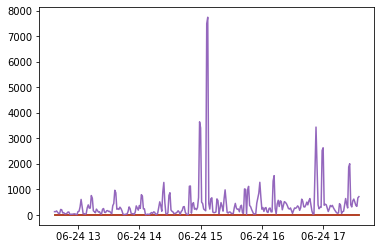

MACD_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Name: histogram, Length: 299, dtype: float64


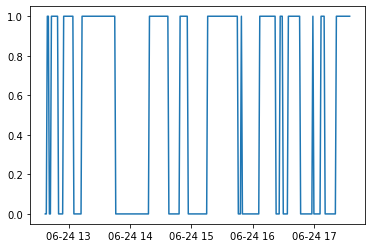

momentum_trigger
time
2020-06-24 12:37:00    1.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Length: 299, dtype: float64


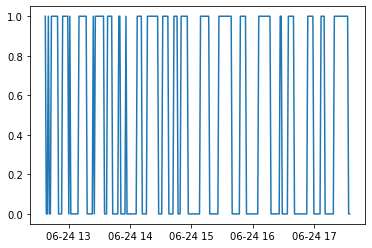

overtraded_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Name: close, Length: 299, dtype: float64


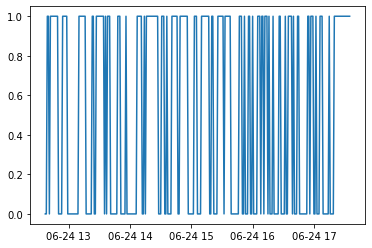

real_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    0.0
Length: 299, dtype: float64


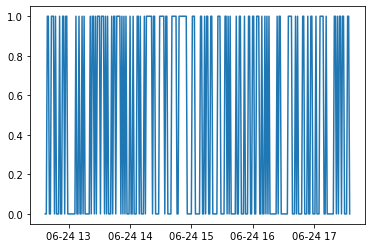

relative_volume_level_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Name: volume, Length: 299, dtype: float64


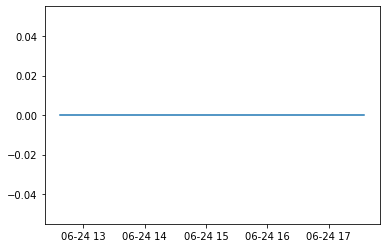

trend_strength_negative_trigger
time
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
2020-06-24 13:07:00    1.0
                      ... 
2020-06-24 17:30:00    0.0
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
Length: 272, dtype: float64


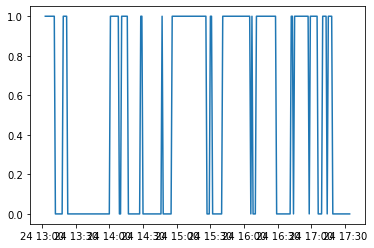

trend_strength_positive_trigger
time
2020-06-24 13:03:00    0.0
2020-06-24 13:04:00    0.0
2020-06-24 13:05:00    0.0
2020-06-24 13:06:00    0.0
2020-06-24 13:07:00    0.0
                      ... 
2020-06-24 17:30:00    1.0
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
Length: 272, dtype: float64


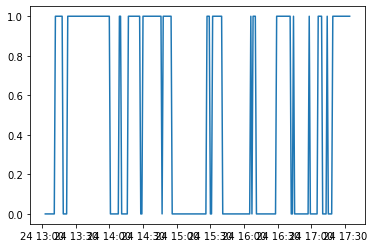

trend_strength_trigger
time
2020-06-24 13:03:00    0.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
2020-06-24 13:07:00    1.0
                      ... 
2020-06-24 17:30:00    1.0
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
Name: ADX, Length: 272, dtype: float64


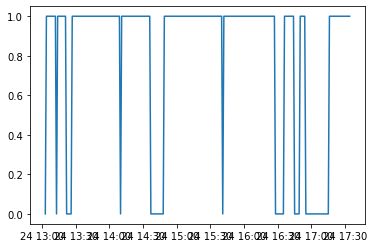

trend_trigger
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 299, dtype: float64


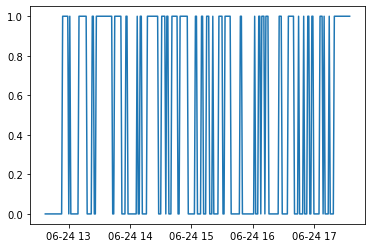

volatility_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Length: 299, dtype: float64


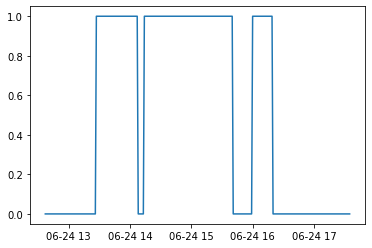

pair:  BNBUSDT
interval:  1m
ATR
time
2020-06-24 12:37:00    0.009479
2020-06-24 12:38:00    0.009479
2020-06-24 12:39:00    0.009479
2020-06-24 12:40:00    0.009479
2020-06-24 12:41:00    0.009479
                         ...   
2020-06-24 17:32:00    0.012364
2020-06-24 17:33:00    0.012267
2020-06-24 17:34:00    0.012369
2020-06-24 17:35:00    0.012485
2020-06-24 17:36:00    0.011972
Length: 300, dtype: float64


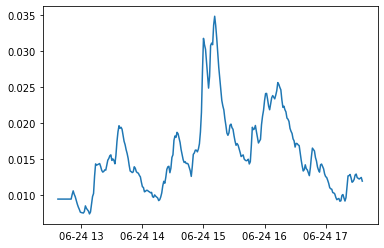

KDJ
                             K          D           J
time                                                 
2020-06-24 12:37:00  55.913978  51.971326   63.799283
2020-06-24 12:38:00  65.558814  56.500489   83.675464
2020-06-24 12:39:00  66.269979  59.756985   79.295965
2020-06-24 12:40:00  70.590242  63.368071   85.034584
2020-06-24 12:41:00  74.752469  67.162870   89.931667
...                        ...        ...         ...
2020-06-24 17:32:00  68.332752  78.564246   47.869763
2020-06-24 17:33:00  61.497197  72.875230   38.741131
2020-06-24 17:34:00  73.027117  72.925859   73.229633
2020-06-24 17:35:00  82.018078  75.956598   94.141037
2020-06-24 17:36:00  86.574143  79.495780  100.730870

[300 rows x 3 columns]


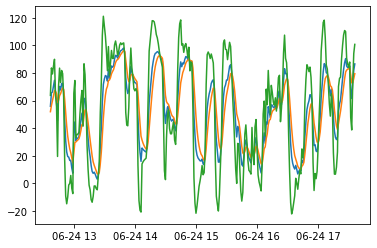

MACD
                         MACD  signal_line  histogram
time                                                 
2020-06-24 12:37:00  0.000034     0.000034   0.000000
2020-06-24 12:38:00  0.000034     0.000034   0.000000
2020-06-24 12:39:00  0.000055     0.000043   0.000013
2020-06-24 12:40:00  0.000118     0.000068   0.000050
2020-06-24 12:41:00  0.000169     0.000098   0.000071
...                       ...          ...        ...
2020-06-24 17:32:00  0.012053     0.010245   0.001808
2020-06-24 17:33:00  0.011614     0.010519   0.001096
2020-06-24 17:34:00  0.012024     0.010820   0.001204
2020-06-24 17:35:00  0.012479     0.011152   0.001327
2020-06-24 17:36:00  0.012606     0.011442   0.001163

[300 rows x 3 columns]


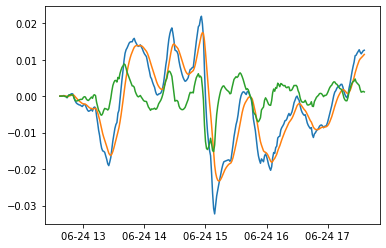

RSI_12
time
2020-06-24 12:37:00    100.000000
2020-06-24 12:38:00    100.000000
2020-06-24 12:39:00    100.000000
2020-06-24 12:40:00    100.000000
2020-06-24 12:41:00    100.000000
                          ...    
2020-06-24 17:32:00     53.775092
2020-06-24 17:33:00     57.334557
2020-06-24 17:34:00     68.080337
2020-06-24 17:35:00     70.745702
2020-06-24 17:36:00     68.557314
Name: close, Length: 300, dtype: float64


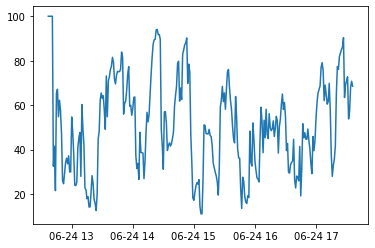

RSI_6
time
2020-06-24 12:37:00    100.000000
2020-06-24 12:38:00    100.000000
2020-06-24 12:39:00    100.000000
2020-06-24 12:40:00    100.000000
2020-06-24 12:41:00    100.000000
                          ...    
2020-06-24 17:32:00     39.348271
2020-06-24 17:33:00     48.292375
2020-06-24 17:34:00     70.682863
2020-06-24 17:35:00     75.271552
2020-06-24 17:36:00     70.289512
Name: close, Length: 300, dtype: float64


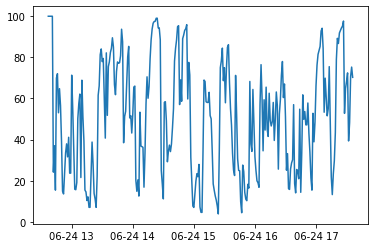

average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-24 13:03:00  0.396349  0.091711  0.358053
2020-06-24 13:04:00  0.383939  0.146842  0.281366
2020-06-24 13:05:00  0.350715  0.183575  0.253509
2020-06-24 13:06:00  0.322839  0.162574  0.224507
2020-06-24 13:07:00  0.314325  0.143979  0.247185
...                       ...       ...       ...
2020-06-24 17:31:00  0.477145  0.235676  0.157826
2020-06-24 17:32:00  0.439905  0.205859  0.137858
2020-06-24 17:33:00  0.435848  0.287438  0.120426
2020-06-24 17:34:00  0.439586  0.282623  0.103505
2020-06-24 17:35:00  0.442825  0.242655  0.088867

[273 rows x 3 columns]


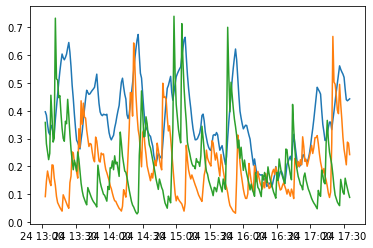

bollinger_bands
                         BB_up    BB_down  BB_width
time                                               
2020-06-24 12:56:00  16.072505  16.072505  0.000000
2020-06-24 12:57:00  16.072117  16.071893  0.000224
2020-06-24 12:58:00  16.071554  16.070966  0.000589
2020-06-24 12:59:00  16.071015  16.069975  0.001040
2020-06-24 13:00:00  16.070727  16.069263  0.001464
...                        ...        ...       ...
2020-06-24 17:32:00  15.989610  15.972970  0.016640
2020-06-24 17:33:00  15.991575  15.974115  0.017461
2020-06-24 17:34:00  15.994313  15.975947  0.018365
2020-06-24 17:35:00  15.997751  15.978329  0.019422
2020-06-24 17:36:00  16.001584  15.980956  0.020628

[281 rows x 3 columns]


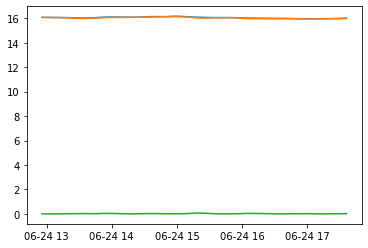

commodity_channel_index
time
2020-06-24 12:37:00         NaN
2020-06-24 12:38:00         NaN
2020-06-24 12:39:00         NaN
2020-06-24 12:40:00         NaN
2020-06-24 12:41:00         NaN
                         ...   
2020-06-24 17:32:00    0.931068
2020-06-24 17:33:00    0.799085
2020-06-24 17:34:00    1.057996
2020-06-24 17:35:00    1.169005
2020-06-24 17:36:00    1.119234
Name: CCI, Length: 300, dtype: float64


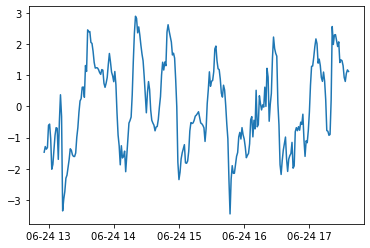

exponential_moving_average
                          open       high        low      close       volume
time                                                                        
2020-06-24 12:37:00  16.072500  16.077000  16.067700  16.074000   128.860000
2020-06-24 12:38:00  16.073550  16.076475  16.067250  16.075125   276.820000
2020-06-24 12:39:00  16.073446  16.078985  16.069154  16.075662   266.892308
2020-06-24 12:40:00  16.076520  16.078320  16.069320  16.076835   346.993000
2020-06-24 12:41:00  16.077243  16.078039  16.072988  16.077548   361.771818
...                        ...        ...        ...        ...          ...
2020-06-24 17:32:00  16.007085  16.008557  15.999138  16.000600  1021.089322
2020-06-24 17:33:00  16.001762  16.003919  15.998179  16.000400   906.363107
2020-06-24 17:34:00  16.001121  16.008973  15.999926  16.007733  1254.994369
2020-06-24 17:35:00  16.008640  16.012858  16.006309  16.012444   767.798123
2020-06-24 17:36:00  16.012413  16.013819  16.011

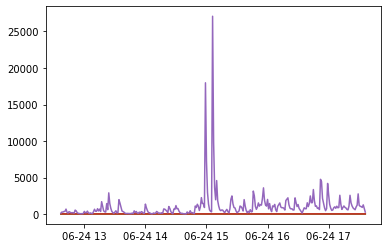

heikin_ashi
                          open     high        low      close
2020-06-24 12:37:00  16.072500  16.0770  10.715200  10.715200
2020-06-24 12:38:00  13.393850  16.0763  10.715467  10.715467
2020-06-24 12:39:00  12.054658  16.0801  10.716567  10.716567
2020-06-24 12:40:00  11.385613  16.0780  10.717133  10.717133
2020-06-24 12:41:00  11.051373  16.0779  10.718033  10.718033
...                        ...      ...        ...        ...
2020-06-24 17:32:00  10.670112  16.0083  10.668533  10.668533
2020-06-24 17:33:00  10.669323  16.0016  10.666450  10.666450
2020-06-24 17:34:00  10.667886  16.0115  10.667886  10.670750
2020-06-24 17:35:00  10.669318  16.0148  10.669318  10.675250
2020-06-24 17:36:00  10.672284  16.0143  10.672284  10.676000

[300 rows x 4 columns]


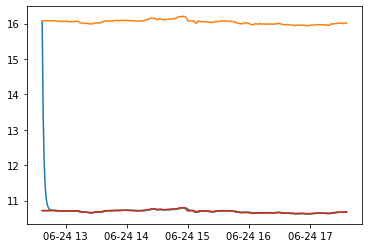

relative_volume_level
                       volume
time                         
2020-06-24 12:37:00       NaN
2020-06-24 12:38:00  0.000000
2020-06-24 12:39:00  0.000000
2020-06-24 12:40:00  0.000000
2020-06-24 12:41:00  0.000000
...                       ...
2020-06-24 17:32:00  0.028154
2020-06-24 17:33:00  0.017928
2020-06-24 17:34:00  0.004369
2020-06-24 17:35:00 -0.156044
2020-06-24 17:36:00 -0.066244

[300 rows x 1 columns]


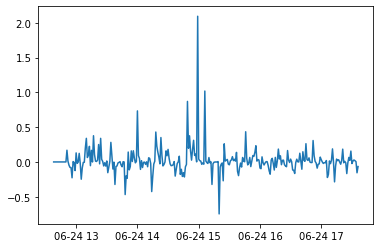

simple_moving_average
                         open      high       low     close    volume
time                                                                 
2020-06-24 12:37:00  16.07320  16.07665  16.06740  16.07475   227.500
2020-06-24 12:38:00  16.07320  16.07665  16.06740  16.07475   227.500
2020-06-24 12:39:00  16.07365  16.07820  16.06855  16.07570   294.310
2020-06-24 12:40:00  16.07570  16.07905  16.06970  16.07665   324.020
2020-06-24 12:41:00  16.07780  16.07795  16.07210  16.07765   377.315
...                       ...       ...       ...       ...       ...
2020-06-24 17:32:00  16.00665  16.00835  16.00045  16.00285   995.300
2020-06-24 17:33:00  16.00370  16.00495  15.99750  15.99880   925.645
2020-06-24 17:34:00  15.99995  16.00655  15.99925  16.00585  1139.155
2020-06-24 17:35:00  16.00660  16.01315  16.00515  16.01310   976.755
2020-06-24 17:36:00  16.01335  16.01455  16.01160  16.01425   270.495

[300 rows x 5 columns]


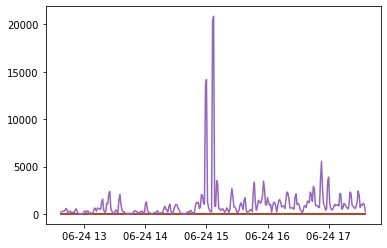

MACD_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    1.0
                      ... 
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
2020-06-24 17:36:00    1.0
Name: histogram, Length: 300, dtype: float64


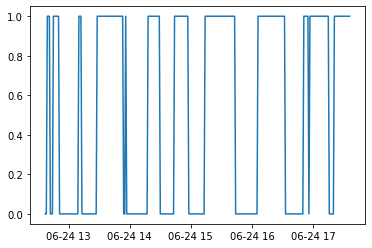

momentum_trigger
time
2020-06-24 12:37:00    1.0
2020-06-24 12:38:00    1.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    1.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
2020-06-24 17:36:00    1.0
Length: 300, dtype: float64


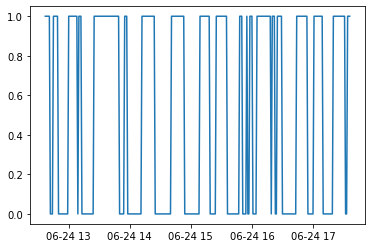

overtraded_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
2020-06-24 17:36:00    1.0
Name: close, Length: 300, dtype: float64


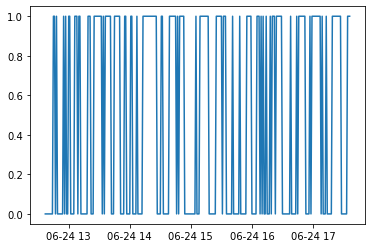

real_trigger
time
2020-06-24 12:37:00    1.0
2020-06-24 12:38:00    1.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    1.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
2020-06-24 17:36:00    0.0
Length: 300, dtype: float64


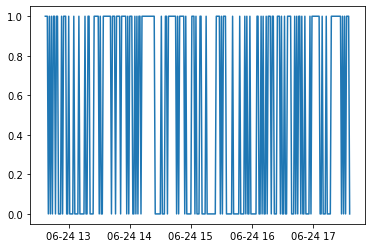

relative_volume_level_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
2020-06-24 17:36:00    0.0
Name: volume, Length: 300, dtype: float64


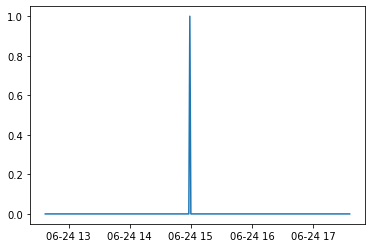

trend_strength_negative_trigger
time
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
2020-06-24 13:07:00    1.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Length: 273, dtype: float64


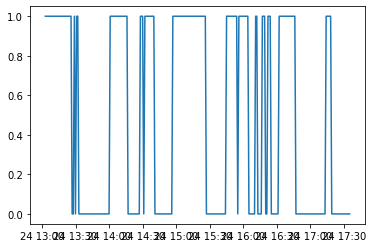

trend_strength_positive_trigger
time
2020-06-24 13:03:00    0.0
2020-06-24 13:04:00    0.0
2020-06-24 13:05:00    0.0
2020-06-24 13:06:00    0.0
2020-06-24 13:07:00    0.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 273, dtype: float64


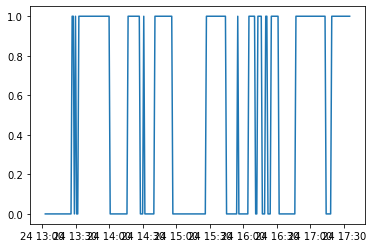

trend_strength_trigger
time
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
2020-06-24 13:07:00    1.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Name: ADX, Length: 273, dtype: float64


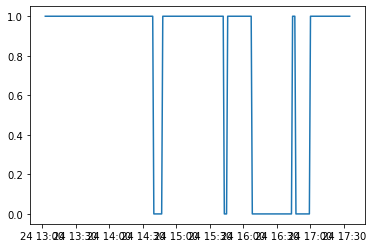

trend_trigger
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
2020-06-24 17:36:00    1.0
Length: 300, dtype: float64


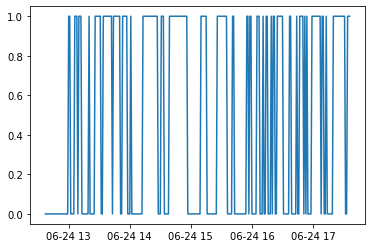

volatility_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
2020-06-24 17:36:00    1.0
Length: 300, dtype: float64


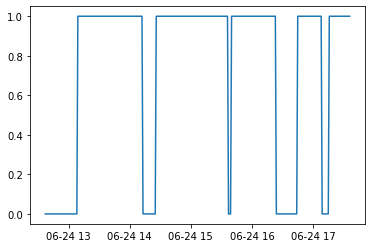

pair:  BTCUSDT
interval:  1m
ATR
time
2020-06-24 12:37:00    3.580898
2020-06-24 12:38:00    3.580898
2020-06-24 12:39:00    3.580898
2020-06-24 12:40:00    3.580898
2020-06-24 12:41:00    3.580898
                         ...   
2020-06-24 17:32:00    6.121099
2020-06-24 17:33:00    5.973164
2020-06-24 17:34:00    5.720795
2020-06-24 17:35:00    5.461452
2020-06-24 17:36:00    5.129920
Length: 300, dtype: float64


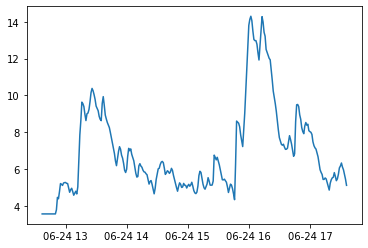

KDJ
                             K          D          J
time                                                
2020-06-24 12:37:00  51.229105  50.409702  52.867912
2020-06-24 12:38:00  43.455062  48.091489  34.182210
2020-06-24 12:39:00  53.001049  49.728009  59.547130
2020-06-24 12:40:00  49.965816  49.807278  50.282892
2020-06-24 12:41:00  47.167133  48.927230  43.646940
...                        ...        ...        ...
2020-06-24 17:32:00  33.330364  50.207204  -0.423314
2020-06-24 17:33:00  29.293818  43.236075   1.409303
2020-06-24 17:34:00  30.884783  39.118978  14.416394
2020-06-24 17:35:00  30.715240  36.317732  19.510256
2020-06-24 17:36:00  30.602211  34.412558  22.981517

[300 rows x 3 columns]


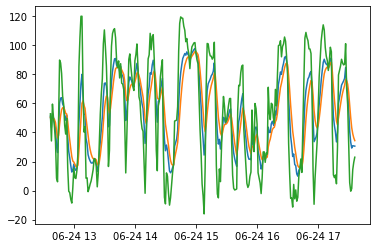

MACD
                         MACD  signal_line  histogram
time                                                 
2020-06-24 12:37:00 -0.019295    -0.019295   0.000000
2020-06-24 12:38:00 -0.019295    -0.019295   0.000000
2020-06-24 12:39:00  0.022550    -0.002145   0.024695
2020-06-24 12:40:00  0.006007     0.000616   0.005391
2020-06-24 12:41:00 -0.006292    -0.001439  -0.004853
...                       ...          ...        ...
2020-06-24 17:32:00  3.967080     4.470302  -0.503222
2020-06-24 17:33:00  3.597637     4.295769  -0.698132
2020-06-24 17:34:00  3.411576     4.118931  -0.707354
2020-06-24 17:35:00  3.185442     3.932233  -0.746791
2020-06-24 17:36:00  2.971970     3.740181  -0.768210

[300 rows x 3 columns]


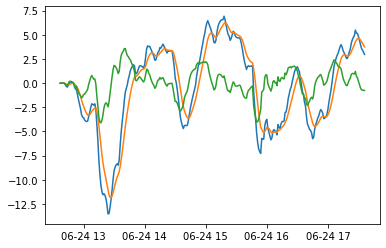

RSI_12
time
2020-06-24 12:37:00     0.000000
2020-06-24 12:38:00     0.000000
2020-06-24 12:39:00    67.626935
2020-06-24 12:40:00    44.787530
2020-06-24 12:41:00    43.360053
                         ...    
2020-06-24 17:32:00    45.434369
2020-06-24 17:33:00    46.952356
2020-06-24 17:34:00    53.400970
2020-06-24 17:35:00    51.284663
2020-06-24 17:36:00    51.284663
Name: close, Length: 300, dtype: float64


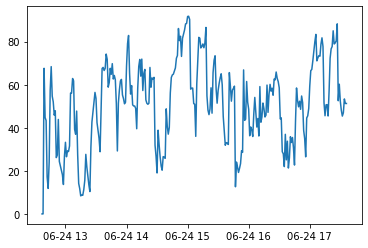

RSI_6
time
2020-06-24 12:37:00     0.000000
2020-06-24 12:38:00     0.000000
2020-06-24 12:39:00    71.220098
2020-06-24 12:40:00    43.527970
2020-06-24 12:41:00    41.657551
                         ...    
2020-06-24 17:32:00    33.394198
2020-06-24 17:33:00    37.581941
2020-06-24 17:34:00    54.455933
2020-06-24 17:35:00    49.116410
2020-06-24 17:36:00    49.116410
Name: close, Length: 300, dtype: float64


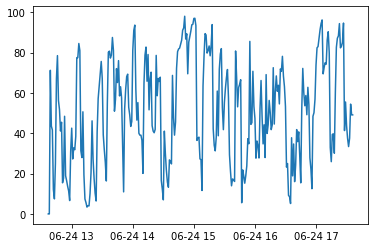

average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-24 13:03:00  0.704879  0.040965  0.251544
2020-06-24 13:04:00  0.612764  0.188162  0.227564
2020-06-24 13:05:00  0.524426  0.184548  0.191065
2020-06-24 13:06:00  0.458584  0.188756  0.162756
2020-06-24 13:07:00  0.406337  0.177204  0.145999
...                       ...       ...       ...
2020-06-24 17:31:00  0.373847  0.173780  0.163294
2020-06-24 17:32:00  0.336173  0.176046  0.146592
2020-06-24 17:33:00  0.304644  0.159031  0.130193
2020-06-24 17:34:00  0.277319  0.143907  0.117812
2020-06-24 17:35:00  0.253637  0.130641  0.106952

[273 rows x 3 columns]


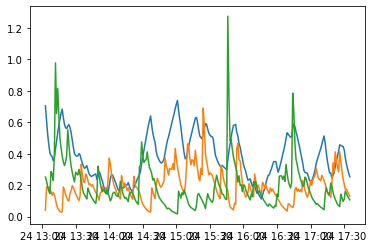

bollinger_bands
                           BB_up      BB_down  BB_width
time                                                   
2020-06-24 12:56:00  9315.351000  9315.351000  0.000000
2020-06-24 12:57:00  9314.656904  9314.257096  0.399809
2020-06-24 12:58:00  9313.855862  9312.908138  0.947724
2020-06-24 12:59:00  9313.157029  9311.575971  1.581057
2020-06-24 13:00:00  9312.594396  9310.351604  2.242792
...                          ...          ...       ...
2020-06-24 17:32:00  9298.624140  9289.309860  9.314279
2020-06-24 17:33:00  9298.672475  9289.732525  8.939949
2020-06-24 17:34:00  9299.033861  9290.485139  8.548721
2020-06-24 17:35:00  9299.443914  9291.290086  8.153828
2020-06-24 17:36:00  9299.826887  9292.008113  7.818774

[281 rows x 3 columns]


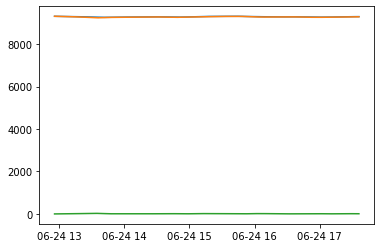

commodity_channel_index
time
2020-06-24 12:37:00         NaN
2020-06-24 12:38:00         NaN
2020-06-24 12:39:00         NaN
2020-06-24 12:40:00         NaN
2020-06-24 12:41:00         NaN
                         ...   
2020-06-24 17:32:00    0.127743
2020-06-24 17:33:00    0.293016
2020-06-24 17:34:00    0.357098
2020-06-24 17:35:00    0.322055
2020-06-24 17:36:00    0.190373
Name: CCI, Length: 300, dtype: float64


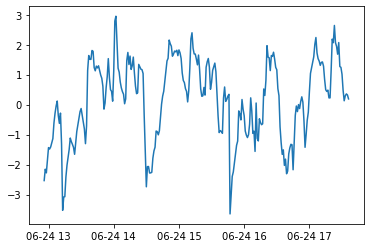

exponential_moving_average
                            open         high          low        close  \
time                                                                      
2020-06-24 12:37:00  9317.720000  9320.940000  9317.550000  9319.370000   
2020-06-24 12:38:00  9319.347500  9320.977500  9317.820000  9318.725000   
2020-06-24 12:39:00  9318.760769  9320.529231  9318.138462  9319.628462   
2020-06-24 12:40:00  9319.617500  9320.361000  9318.760500  9319.244750   
2020-06-24 12:41:00  9319.873554  9320.119339  9318.606198  9319.067521   
...                          ...          ...          ...          ...   
2020-06-24 17:32:00  9297.053634  9298.069348  9293.978742  9295.887223   
2020-06-24 17:33:00  9296.091211  9297.823116  9294.832914  9295.775741   
2020-06-24 17:34:00  9295.850404  9297.821039  9295.430971  9296.945247   
2020-06-24 17:35:00  9297.150135  9297.820346  9296.476990  9296.988416   
2020-06-24 17:36:00  9297.050045  9297.280115  9296.825663  9297.002805  

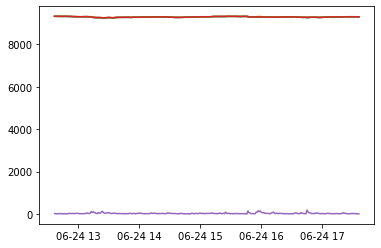

heikin_ashi
                            open     high          low        close
2020-06-24 12:37:00  9317.720000  9320.94  6212.596667  6212.596667
2020-06-24 12:38:00  7765.158333  9320.99  6212.883333  6212.883333
2020-06-24 12:39:00  6989.020833  9320.33  6212.856667  6212.856667
2020-06-24 12:40:00  6600.938750  9320.28  6213.071667  6213.071667
2020-06-24 12:41:00  6407.005208  9320.00  6212.918333  6212.918333
...                          ...      ...          ...          ...
2020-06-24 17:32:00  6199.196189  9296.78  6196.838333  6196.838333
2020-06-24 17:33:00  6198.017261  9297.70  6197.381667  6197.381667
2020-06-24 17:34:00  6197.699464  9297.82  6197.699464  6197.801667
2020-06-24 17:35:00  6197.750565  9297.82  6197.750565  6198.271667
2020-06-24 17:36:00  6198.011116  9297.01  6198.003333  6198.003333

[300 rows x 4 columns]


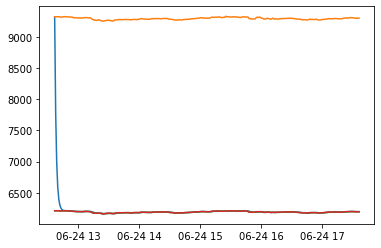

relative_volume_level
                       volume
time                         
2020-06-24 12:37:00       NaN
2020-06-24 12:38:00  0.000000
2020-06-24 12:39:00  0.000000
2020-06-24 12:40:00  0.000000
2020-06-24 12:41:00  0.000000
...                       ...
2020-06-24 17:32:00  0.064272
2020-06-24 17:33:00 -0.088930
2020-06-24 17:34:00 -0.084959
2020-06-24 17:35:00 -0.269933
2020-06-24 17:36:00 -0.038485

[300 rows x 1 columns]


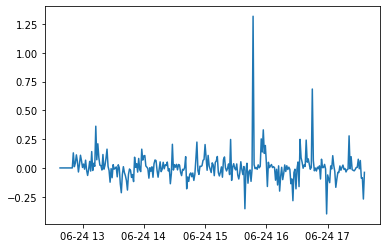

simple_moving_average
                         open      high       low     close     volume
time                                                                  
2020-06-24 12:37:00  9318.805  9320.965  9317.730  9318.940  16.536932
2020-06-24 12:38:00  9318.805  9320.965  9317.730  9318.940  16.536932
2020-06-24 12:39:00  9319.195  9320.660  9318.095  9319.270   9.100926
2020-06-24 12:40:00  9319.265  9320.305  9318.670  9319.545   7.509803
2020-06-24 12:41:00  9320.015  9320.140  9318.795  9319.020   7.911525
...                       ...       ...       ...       ...        ...
2020-06-24 17:32:00  9297.065  9297.670  9294.400  9295.785  17.295836
2020-06-24 17:33:00  9295.920  9297.240  9293.995  9295.505  17.947024
2020-06-24 17:34:00  9295.670  9297.760  9295.495  9296.625   6.602341
2020-06-24 17:35:00  9296.765  9297.820  9296.365  9297.270   3.515006
2020-06-24 17:36:00  9297.400  9297.415  9297.000  9297.010   1.708803

[300 rows x 5 columns]


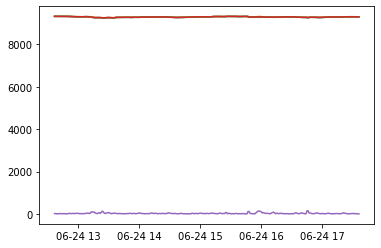

MACD_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
2020-06-24 17:36:00    0.0
Name: histogram, Length: 300, dtype: float64


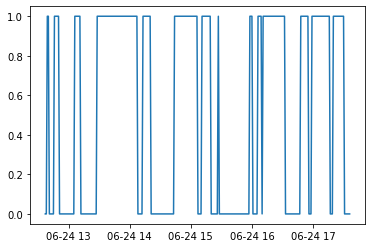

momentum_trigger
time
2020-06-24 12:37:00    1.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    1.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
2020-06-24 17:36:00    0.0
Length: 300, dtype: float64


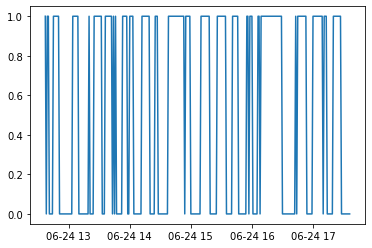

overtraded_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    0.0
2020-06-24 17:36:00    0.0
Name: close, Length: 300, dtype: float64


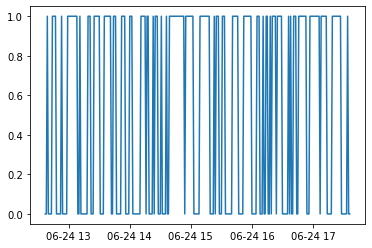

real_trigger
time
2020-06-24 12:37:00    1.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    1.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    0.0
2020-06-24 17:36:00    1.0
Length: 300, dtype: float64


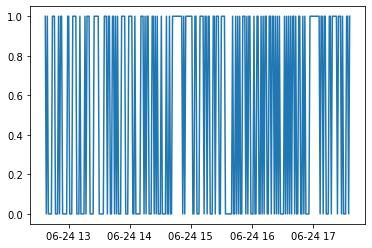

relative_volume_level_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
2020-06-24 17:36:00    0.0
Name: volume, Length: 300, dtype: float64


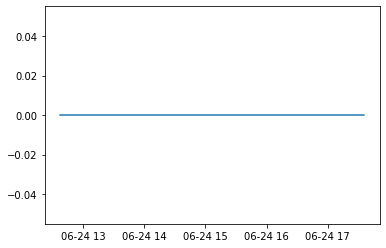

trend_strength_negative_trigger
time
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    0.0
2020-06-24 13:07:00    0.0
                      ... 
2020-06-24 17:31:00    0.0
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    0.0
2020-06-24 17:35:00    0.0
Length: 273, dtype: float64


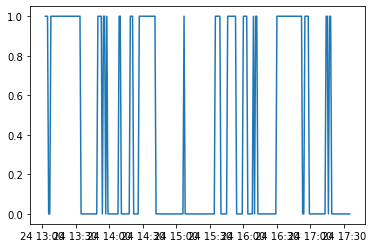

trend_strength_positive_trigger
time
2020-06-24 13:03:00    0.0
2020-06-24 13:04:00    0.0
2020-06-24 13:05:00    0.0
2020-06-24 13:06:00    1.0
2020-06-24 13:07:00    1.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Length: 273, dtype: float64


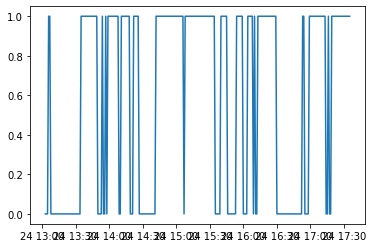

trend_strength_trigger
time
2020-06-24 13:03:00    1.0
2020-06-24 13:04:00    1.0
2020-06-24 13:05:00    1.0
2020-06-24 13:06:00    1.0
2020-06-24 13:07:00    1.0
                      ... 
2020-06-24 17:31:00    1.0
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
Name: ADX, Length: 273, dtype: float64


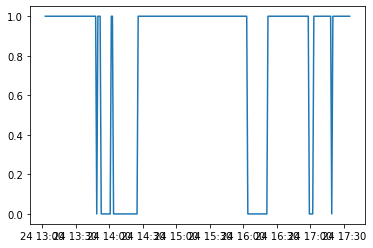

trend_trigger
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    0.0
2020-06-24 17:33:00    0.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
2020-06-24 17:36:00    0.0
Length: 300, dtype: float64


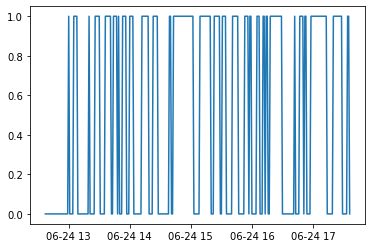

volatility_trigger
time
2020-06-24 12:37:00    0.0
2020-06-24 12:38:00    0.0
2020-06-24 12:39:00    0.0
2020-06-24 12:40:00    0.0
2020-06-24 12:41:00    0.0
                      ... 
2020-06-24 17:32:00    1.0
2020-06-24 17:33:00    1.0
2020-06-24 17:34:00    1.0
2020-06-24 17:35:00    1.0
2020-06-24 17:36:00    1.0
Length: 300, dtype: float64


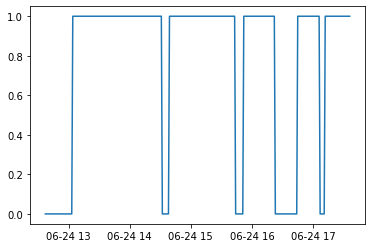

In [5]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                assets=assets, 
                                intervals=intervals, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot, 
                                all_pairs=all_pairs)

In [ ]:
def process_message(msg):
    global crypto_bot

    percentage_to_trade = 0.99999999

    msg = msg['data']['k']
    symbol = msg['s']

    if symbol in crypto_bot.pairs.keys():
        interval = msg['i']

        pair = crypto_bot.pairs[symbol]
        pair_at_interval = pair.interval[interval]

        dataset = pair.get_OHLCV(interval=interval, 
                                 open=msg['o'], 
                                 high=msg['h'], 
                                 low=msg['l'], 
                                 close=msg['c'], 
                                 volume=msg['v'], 
                                 timestamp=msg['t'])

        pair_at_interval.indicators.update(dataset, plot=False)
        pair.info.calculate_balance()
        pair.info.print_balance()

        if symbol == crypto_bot.pair:
            volatility_trigger = pair_at_interval.indicators.indicators.volatility_trigger.value.iloc[-1]
            MACD_trigger = pair_at_interval.indicators.indicators.MACD_trigger.value.iloc[-1]
            real_trigger = pair_at_interval.indicators.indicators.real_trigger.value.iloc[-1]
            momentum_trigger = pair_at_interval.indicators.indicators.momentum_trigger.value.iloc[-1]

            if pair.state == 'exit':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

            elif pair.state == 'entry':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)


bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for pair in crypto_bot.pairs.keys():
        sockets.append(pair.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)
bm.start()


while True:
    time.sleep(30)

    crypto_bot.assets = dict.fromkeys(crypto_bot.assets.keys(), 0)

    for symbol, pair in crypto_bot.pairs.items():
        pair.info.calculate_balance()
        pair.calculate_position()

    for asset_symbol, asset in crypto_bot.assets.items():
        for pair_symbol, pair in crypto_bot.pairs.items():
            if pair.info.base_asset == asset_symbol:
                if pair.interval[intervals[0]].indicators.indicators.real_trigger.value.iloc[-1] and \
                        pair.interval[intervals[0]].indicators.indicators.relative_volume_level_trigger.value.iloc[-1]:

                    asset += 1

                else:
                    asset -= 1

            elif pair.info.quote_asset == asset_symbol:
                if pair.interval[intervals[0]].indicators.indicators.real_trigger.value.iloc[-1] and \
                        pair.interval[intervals[0]].indicators.indicators.relative_volume_level_trigger.value.iloc[-1]:

                    asset -= 1

                else:
                    asset += 1

    #crypto_bot.assets['BTC'] = 0 # Using BTC as communicating pair.
    best_assets = [symbol for symbol, asset in crypto_bot.assets.items() if asset > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (crypto_bot.pairs[crypto_bot.pair].info.base_asset in best_assets or \
            crypto_bot.pairs[crypto_bot.pair].info.quote_asset in best_assets):

        if crypto_bot.pairs[crypto_bot.pair].position == 'buy':
            asset = crypto_bot.pairs[crypto_bot.pair].info.base_asset
        elif crypto_bot.pairs[crypto_bot.pair].position == 'sell':
            asset = crypto_bot.pairs[crypto_bot.pair].info.quote_asset

        pairs = [pair for pair in crypto_bot.pairs.keys() \
                 if asset in pair and any([asset in pair for asset in best_assets])]

        pair = pairs[0]
        crypto_bot.pairs[pair].state = 'exit'

        if crypto_bot.pairs[pair].info.base_asset == asset:
            crypto_bot.pairs[pair].position = 'buy'
            crypto_bot.asset = crypto_bot.pairs[pair].info.base_asset
        elif crypto_bot.pairs[pair].info.quote_asset == asset:
            crypto_bot.pairs[pair].position = 'sell'
            crypto_bot.asset = crypto_bot.pairs[pair].info.quote_asset

        crypto_bot.pair = pair



pair:  BTCUSDT
base_asset_balance:  0.00782029
quote_asset_balance:  0
pair_last_price:  9291.24
pair_buy_balance:  0
pair_sell_balance:  72.66019126
pair_combined_base_balance:  0.00782029
pair_combined_quote_balance:  72.66019126




pair:  BNBBTC
base_asset_balance:  0.00266965
quote_asset_balance:  0.00782029
pair_last_price:  0.001722
pair_buy_balance:  4.54139954
pair_sell_balance:  0.0000046
pair_combined_base_balance:  4.54406919
pair_combined_quote_balance:  0.00782489




pair:  BTCUSDT
base_asset_balance:  0.00782029
quote_asset_balance:  0
pair_last_price:  9291.24
pair_buy_balance:  0
pair_sell_balance:  72.66019126
pair_combined_base_balance:  0.00782029
pair_combined_quote_balance:  72.66019126




pair:  BTCUSDT
base_asset_balance:  0.00782029
quote_asset_balance:  0
pair_last_price:  9291.35
pair_buy_balance:  0
pair_sell_balance:  72.66105149
pair_combined_base_balance:  0.00782029
pair_combined_quote_balance:  72.66105149




pair:  BNBBTC
base_asset_balance:  0.00

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()